In [1]:
# File Name: ECCOv4r4_air_sea_flux_temp_analysis.ipynb

# Description: This jupyter notebook contains code that renders time-series plots of 
# many relevant oceanographic flux variables over the ECCO version 4 release 4 time period
# of 1992 - 2017. The author has chosen to operate on monthly_mean datasets as opposed 
# to daily_mean and/or daily_snap datasets for convenience.
# Attempts by the user were made to connect trends in the time-series plots to
#real-world phenomena, and each of the plots are explained from a mathematical point of view

## Initialize Python Libraries

In [2]:
## Import the ecco_v4_py library into Python
## =========================================
## -- If ecco_v4_py is not installed in your local Python library,
##    tell Python where to find it.  

import sys
sys.path.append('/scratch2/jcam98/CRIOS/ECCO_analysis_work/ECCOv4-py/ecco_v4_py') # sverdrup
import ecco_v4_py as ecco

# Initialize Python libraries 

import numpy as np
import PIL.Image
import pandas as pd
import requests
import shutil
import time as time
import glob
import matplotlib.pyplot as plt
import os
base_repo_dir = os.getcwd()
# Define file path to '/output' directory to store figures rendered in this notebook locally

output_dir = '/scratch2/jcam98/CRIOS/ECCO_analysis_work/ECCO_V4R4_Analysis/' \
                'ECCO_V4R4_Analysis/projects/air_sea_flux_temp_analysis/output/plots'
#import xgcm

# to read and plot the downloaded NetCDF files
# assuming ecco_v4_py package has been installed in ECCOv4-py directory
# otherwise change sys.path.append as needed
import xarray as xr
from os.path import join,expanduser
import matplotlib.pyplot as plt

# for concurrent simulatenous downloads
from concurrent.futures import ThreadPoolExecutor
from getpass import getpass
from http.cookiejar import CookieJar
from io import StringIO
from itertools import repeat
from pathlib import Path
from platform import system
from netrc import netrc
from os.path import basename, isfile, isdir
# progress bar
from tqdm import tqdm
# library to download files
from urllib import request
from ecco_download import *

# Define file path to top-level eccov4r4 llc90 directory

eccov4r4_llc90_sverdrup = '/scratch2/jcam98/CRIOS/ECCO_analysis_work/datasets/v4r4/restruct_output/llc90'

## Define Helper Subroutines

## Helper subroutine to log into NASA EarthData

In [3]:
def setup_earthdata_login_auth(machine: str, url: str='urs.earthdata.nasa.gov'):
    # look for the netrc file on local machine and use the login/password
    # add another branch to 'if' statement below to specify name of local 
    # machine and filepath on that machine to netrc file for authentication
    try:
        if (machine == "sverdrup"):
            username, _, password = netrc(file='/home/jcam98/.netrc').authenticators(url)
        elif (machine == "stampede2"):
            username, _, password = netrc(file='/home1/07674/jcam98/.netrc').authenticators(url)
    # if the file is not found, prompt the user for the login/password
    except (FileNotFoundError, TypeError):
        print('Please provide Earthdata Login credentials for access.')
        username, password = input('Username: '), getpass('Password: ')

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, url, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)

## Helper subroutines to make the API calls to search CMR and parse response

In [4]:
def set_params(params: dict):
    params.update({'scroll': "true", 'page_size': 2000})
    return {par: val for par, val in params.items() if val is not None}

def get_results(params: dict, headers: dict=None):
    response = requests.get(url="https://cmr.earthdata.nasa.gov/search/granules.csv",
                            params=set_params(params),
                            headers=headers)
    return response, response.headers


def get_granules(params: dict):
    response, headers = get_results(params=params)
    scroll = headers['CMR-Scroll-Id']
    hits = int(headers['CMR-Hits'])
    if hits==0:
        raise Exception("No granules matched your input parameters.")
    df = pd.read_csv(StringIO(response.text))
    while hits > df.index.size:
        response, _ = get_results(params=params, headers={'CMR-Scroll-Id': scroll})
        data = pd.read_csv(StringIO(response.text))
        df = pd.concat([df, data])
    return df

## Helper subroutine to gracefully download single files and avoids re-downloading if file already exists

In [5]:
# To force redownload of the file, pass **True** to the boolean argument *force* (default **False**)
def download_file(url: str, output_dir: str, force: bool=False):
    """
    url (str): the HTTPS url from which the file will download
    output_dir (str): the local path into which the file will download
    force (bool): download even if the file exists locally already
    """
    if not isdir(output_dir):
        raise Exception(f"Output directory doesnt exist! ({output_dir})")

    target_file = join(output_dir, basename(url))

    # if the file has already been downloaded, skip
    if isfile(target_file) and force is False:
        print(f'\n{basename(url)} already exists, and force=False, not re-downloading')
        return 0

    with requests.get(url) as r:
        if not r.status_code // 100 == 2:
            raise Exception(r.text)
            return 0
        else:
            with open(target_file, 'wb') as f:
                total_size_in_bytes= int(r.headers.get('content-length', 0))
                for chunk in r.iter_content(chunk_size=1024):
                    if chunk:
                        f.write(chunk)

                return total_size_in_bytes

## Helper subroutine to download all urls in the list 'dls'

In [6]:
def download_files_concurrently(dls, download_dir, force=False):
    start_time = time.time()

    # use 3 threads for concurrent downloads
    with ThreadPoolExecutor(max_workers=max_workers) as executor:

        # tqdm makes a cool progress bar
        results = list(tqdm(executor.map(download_file, dls, repeat(download_dir), repeat(force)), total=len(dls)))

        # add up the total downloaded file sizes
        total_download_size_in_bytes = np.sum(np.array(results))
        # calculate total time spent in the download
        total_time = time.time() - start_time

        print('\n=====================================')
        print(f'total downloaded: {np.round(total_download_size_in_bytes/1e6,2)} Mb')
        print(f'avg download speed: {np.round(total_download_size_in_bytes/1e6/total_time,2)} Mb/s') 

## Log into NASA Earthdata account using username and password

In [7]:
# Locally on Sverdrup (Change function argument to coincide with cell 5)
setup_earthdata_login_auth(machine = "sverdrup")

## Opening Monthly Mean State Estimate Variable NetCDF Files

### Load files into python workspace using 'recursive_load_ecco_var_from_years_nc()'

In [8]:
# Change file paths to point to subdirectories where monthly mean data is stored locally
# NOTE: This repository does not contain the monthly mean, daily mean, grid, or other 
# input data used in the analysis and visualization. These datasets must be pulled down
# from the NASA ECCO Drive

llc90_monthly_means_data_dir_sverdrup = eccov4r4_llc90_sverdrup + \
                                        '/monthly_means/nctiles_monthly'

# Define time range for time series analysis
year_start = 1992; year_end = 2017

# Load monthly mean datasets for heat flux properties
heat_flux_monthly_mean_ds = ecco.recursive_load_ecco_var_from_years_nc(\
                            llc90_monthly_means_data_dir_sverdrup, \
                            vars_to_load=['EXFqnet', 'EXFhl', 'EXFhs', 'EXFlwnet', \
                            'EXFswnet', 'SIatmQnt'],\
                            years_to_load=range(year_start, year_end), dask_chunk=True)

# Load monthly mean datasets for freshwater flux properties
freshwater_flux_monthly_mean_ds = ecco.recursive_load_ecco_var_from_years_nc(\
                            llc90_monthly_means_data_dir_sverdrup, \
                            vars_to_load=['EXFempmr', 'EXFevap', 'EXFpreci', 'EXFroff', \
                            'SIatmFW'],\
                            years_to_load=range(year_start, year_end), dask_chunk=True)

# Load monthly mean datasets for sea surface temperature (THETA) properties
SST_monthly_mean_ds = ecco.recursive_load_ecco_var_from_years_nc(\
                        llc90_monthly_means_data_dir_sverdrup, \
                        vars_to_load=['THETA'],\
                        years_to_load=range(year_start, year_end), dask_chunk=True)


loading files of  EXFhl
loading files of  EXFhs
loading files of  EXFlwnet
loading files of  EXFqnet
loading files of  EXFswnet
loading files of  SIatmQnt
loading files of  EXFempmr
loading files of  EXFevap
loading files of  EXFpreci
loading files of  EXFroff
loading files of  SIatmFW
loading files of  THETA


## Initiailize 'grid' object for storing ECCOv4r4 grid parameters

In [9]:
# Initialize grid object to store ECCOv4r4 grid parameters used in evaluating area-weighted
# flux properties 

# Define file path to nctiles_grid 'ECCO-GRID.nc'

ecco_v4r4_grid_data_dir = eccov4r4_llc90_sverdrup + '/grid_files'

# Define 'grid' object
ecco_v4r4_grid = ecco.load_ecco_grid_nc(ecco_v4r4_grid_data_dir, 'ECCO-GRID.nc')

# First, the areas of tracer grid cells masked in seawater must be separated from the areas
# covered by land using the "seawater area/total_area" ratio factor (hFacC)

area_masked = ecco_v4r4_grid.rA*ecco_v4r4_grid.hFacC.isel(k = 0).transpose('tile', 'j', 'i')

# Drop redundant coordinates in flux xarray.Dataset objects that are contained in ecco grid object

heat_flux_monthly_mean_ds = heat_flux_monthly_mean_ds.reset_coords(drop = True)
freshwater_flux_monthly_mean_ds = freshwater_flux_monthly_mean_ds.reset_coords(drop = True)
SST_monthly_mean_ds = SST_monthly_mean_ds.reset_coords(drop = True)

## Analysis of Global Mean Heat Flux for ECCOv4r4 Model Output

In [10]:
# Extract xarray.DataArray objects corresponding to each heat flux property in dataset

EXFqnet_arr = heat_flux_monthly_mean_ds.EXFqnet
EXFhl_arr = heat_flux_monthly_mean_ds.EXFhl
EXFhs_arr = heat_flux_monthly_mean_ds.EXFhs
EXFlwnet_arr = heat_flux_monthly_mean_ds.EXFlwnet
EXFswnet_arr = heat_flux_monthly_mean_ds.EXFswnet
SIatmQnt_arr = heat_flux_monthly_mean_ds.SIatmQnt

## Evaluate Area-Weighted, Horizontally-Averaged Heat Flux Properties from ECCOv4r4 Model Output

In [11]:
# Evaluate horizontally-integrated, area-weighted mean of heat flux properties to obtain 
# one resultant area-weighted mean value for each month in time period

EXFqnet_area_weighted = (EXFqnet_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

EXFhl_area_weighted = (EXFhl_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

EXFhs_area_weighted = (EXFhs_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

EXFlwnet_area_weighted = (EXFlwnet_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

EXFswnet_area_weighted = (EXFswnet_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

SIatmQnt_area_weighted = (SIatmQnt_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

EXFqnet_residual_area_weighted = EXFqnet_area_weighted - (-EXFhl_area_weighted - \
                                 EXFhs_area_weighted + EXFlwnet_area_weighted + \
                                 EXFswnet_area_weighted)

# Convert area weighted xarray objects into numpy arrays for plot rendering using Matplotlib

EXFqnet_area_weighted_np = np.array(EXFqnet_area_weighted)
SIatmQnt_area_weighted_np = np.array(SIatmQnt_area_weighted)
EXFqnet_residual_area_weighted_np = np.array(EXFqnet_residual_area_weighted)

## Render Heat Flux Property Time-Series Plots for ECCOv4r4 Model Output

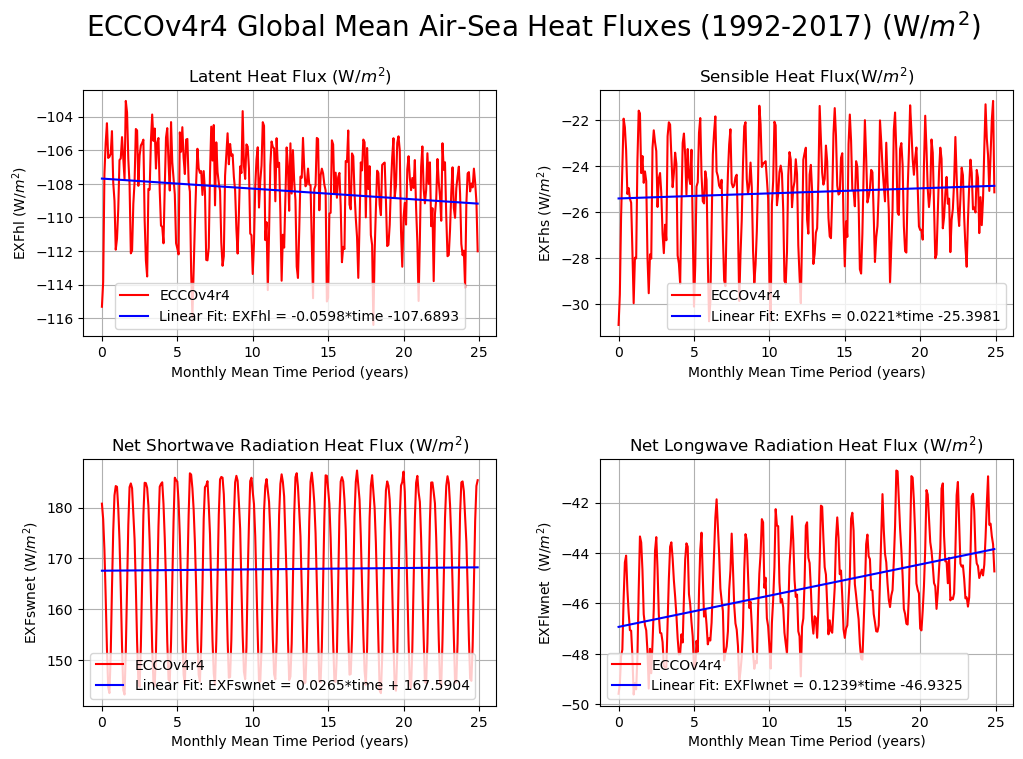

The time mean of global latent heat flux is -108.43384 W/m2
The time mean of global sensible heat flux is -25.12314 W/m2
The time mean of global net shortwave radiation heat flux is 167.91994 W/m2
The time mean of global net longwave heat flux is -45.38937 W/m2


<Figure size 640x480 with 0 Axes>

In [13]:
# Initialize figure geometry with four subplot grids for heat flux property visualizations

fig, axs = plt.subplots(2, 2, figsize = (12,8))
axs = axs.flatten()

# Convert xarray.DataArray objects storing heat flux property values into numpy arrays
# for linear regression model fitting

EXFhl_area_weighted_np = np.array(EXFhl_area_weighted)
EXFhs_area_weighted_np = np.array(EXFhs_area_weighted)
EXFswnet_area_weighted_np = -np.array(EXFswnet_area_weighted)
EXFlwnet_area_weighted_np = -np.array(EXFlwnet_area_weighted)

######## Time Series of Latent Heat Flux 

# Define numpy array with monthly mean time values

time = np.arange(0, 25, 1/12)

plt.sca(axs[0])
axs[0].plot(time, EXFhl_area_weighted_np, color='r')

# Fit Linear Regression Model to EXFhl Time-Series Data

m, b = np.polyfit(time, EXFhl_area_weighted_np, 1) 
m_r = round(m, 4)
b_r = round(b, 4)

# Render Linear Best Fit Line Plot 
axs[0].plot(time, m*time + b, 'b')
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel('EXFhl (W/$m^{2}$)');
plt.legend(['ECCOv4r4', 'Linear Fit: EXFhl = ' + str(m_r) + \
            '*' + 'time ' + str(b_r)]);
plt.title("Latent Heat Flux (W/$m^{2}$)")
plt.grid()

# import scipy
# r = np.corrcoef(time, EXFhl_area_weighted_np)
# s = scipy.stats.spearmanr(time, EXFhl_area_weighted_np)[0]
# k = scipy.stats.kendalltau(time, EXFhl_area_weighted_np)[0]
# print(r)
# print(s)
# print(k)

######## Time Series of Sensible Heat Flux 

plt.sca(axs[1])
axs[1].plot(time, EXFhs_area_weighted_np,color='r')

# Fit Linear Regression Model to EXFhs Time-Series Data

m, b = np.polyfit(time, EXFhs_area_weighted_np, 1) 
m_r = round(m, 4)
b_r = round(b, 4)

# Render Linear Best Fit Line Plot

axs[1].plot(time, m*time + b, 'b')
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel('EXFhs (W/$m^{2}$)');
plt.legend(['ECCOv4r4', 'Linear Fit: EXFhs = ' + str(m_r) + \
            '*' + 'time ' + str(b_r)]);
plt.title("Sensible Heat Flux(W/$m^{2}$)")
plt.grid()

######### Time Series of Shortwave Radiation Heat Flux 

plt.sca(axs[2])
axs[2].plot(time, EXFswnet_area_weighted_np,color='r')

# Fit Linear Regression Model to EXFswnet Time-Series Data

m, b = np.polyfit(time, EXFswnet_area_weighted_np, 1) 
m_r = round(m, 4)
b_r = round(b, 4)

# Render Linear Best Fit Line Plot 

axs[2].plot(time, m*time + b, 'b')
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel('EXFswnet (W/$m^{2}$)');
plt.legend(['ECCOv4r4', 'Linear Fit: EXFswnet = ' + str(m_r) + \
            '*' + 'time + ' + str(b_r)], loc = 'lower left');
plt.title("Net Shortwave Radiation Heat Flux (W/$m^{2}$)")
plt.grid()

######### Time Series of Longwave Radiation Heat Flux

plt.sca(axs[3])
axs[3].plot(time, EXFlwnet_area_weighted_np,color='r')

# Fit Linear Regression Model to EXFlwnet Time-Series Data

m, b = np.polyfit(time, EXFlwnet_area_weighted_np, 1) 
m_r = round(m, 4)
b_r = round(b, 4)

# Render Linear Best Fit Line Plot 

axs[3].plot(time, m*time + b, 'b')
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel('EXFlwnet  (W/$m^{2}$)');
plt.legend(['ECCOv4r4', 'Linear Fit: EXFlwnet = ' + str(m_r) + \
            '*' + 'time ' + str(b_r)], loc = 'lower left');
plt.title("Net Longwave Radiation Heat Flux (W/$m^{2}$)")
plt.grid()

#Render figure title

plt.subplots_adjust(hspace = 0.5, wspace=.25);
plt.suptitle('ECCOv4r4 Global Mean Air-Sea Heat Fluxes (1992-2017) (W/$m^{2}$)',
                 fontsize=20);

plt.show();

# Save figure to local file system as '.png'

plt.savefig(output_dir + '/global_mean_eccov4r4_air_sea_heat_fluxes.png')

# Compute time mean global heat flux property values

EXFhl_time_mean = np.mean(EXFhl_area_weighted_np)
EXFhs_time_mean = np.mean(EXFhs_area_weighted_np)
EXFswnet_time_mean = np.mean(EXFswnet_area_weighted_np)
EXFlwnet_time_mean = np.mean(EXFlwnet_area_weighted_np)
print('The time mean of global latent heat flux is ' + str(EXFhl_time_mean) + ' W/m2')
print('The time mean of global sensible heat flux is ' + str(EXFhs_time_mean) + ' W/m2')
print('The time mean of global net shortwave radiation heat flux is ' + str(EXFswnet_time_mean) + ' W/m2')
print('The time mean of global net longwave heat flux is ' + str(EXFlwnet_time_mean) + ' W/m2')

## Procedure and Analysis of Heat Flux Property Time-Series Plots for ECCOv4r4 Model Output

### Procedure Summary

1. The monthly-mean air-sea heat flux properties from the ECCOv4r4 model datasets (spanning a time period of 1992-2017), were read into a single 'xarray.Dataset' object
2. A netCDF file defining the ECCOv4r4 grid geometry ('ECCO-GRID.nc') was then read into an individual 'xarray.Dataset' object.
3. Next, the grid geometry object was used to develop an array that could be used for masking out tracer grid cells whose sea surface partitions (k=0) are immersed in seawater for area-weighted mean calculations
4. Then, redundant coordinates were dropped from both objects to reduce the workspace's memory footprint.
5. From here, the 'xarray.DataArray' objects corresponding to the individual air-sea heat flux terms were indexed from the first 'xarray.Dataset' object and assigned to individual variables
6. Then, the globally-integrated, area-weighted mean (horizontal spatially-averaged, area-weighted mean) heat flux values were obtained for each month in the time period.
7. Next, the arrays were converted into 'numpy.ndarray' objects to enable rendering of the data using matplotlib plotting routines
8. Then, a figure with time-series line plots of the air-sea heat flux at the sea surface was rendered as shown above, and linear regression was used to fit a first degree polynomial equation to the data.
9. Lastly, the figure was saved to the local file system.

### Analysis of Results

The figure above depicts the global mean heat flux property values from the ECCOv4r4 model output over the time period of 1992-2017 with a linear regression model fit to each dataset. In referencing the time-series plot for the latent heat flux, the linear regression best fit line reflects a negative linear trend in the heat flux over this time period. In observing the assimilated data from the model shown in red, it is evident that are large seasonal fluctuations in the latent heat flux with the largest (cooling) mean values corresponding roughly to the beginning of the calendar year (peak winter season in northern hemisphere) in January - February and the smallest (cooling) mean values corresponding roughly to March - May (the peak spring season in northern hemispere and peak fall season in southern hemisphere respectively). This annual trend is consistent with expectations firstly in that the southern hemisphere's contribution to the global evaporation (latent heat flux) will be the largest (most negative) in January - February in the region's warmer months when localized latent heat fluxes are largest because the mean temperature is high and the most constant of the seasonal periods. Furthermore, the southern hemisphere has approximately 81% of its surface area covered in seawater compared to just 61% for the northern hemisphere meaning that the formers' properties will always domainate the latter. Secondly, this trend agrees with expectations that the magnitude of the global mean latent heat flux will approximately be at a minimum (global mean evaporative flux from the ocean to the atmosphere will be the smallest) during the northern hemisphere's mid-winter-early-spring and the southern hemisphere's mid-summer-early-fall seasons when the temperatures change most rapidly with time and the global mean temperature is smallest. 

In referencing the time-series plot for the sensible heat flux, it is shown that there is a positive linear trend in the global mean sensible heat flux with a rate whose magnitude is approximately twice that of the global mean latent heat flux. The annual trend with seasonal fluctuations in the fluxes' magnitude are almost identical to that of the latent heat flux as expected considering the time-variance in global mean sea surface temperature that governs the sensible heat interactions between the ocean surface and atmosphere. This temperature is again dominated by the southern hemispheres' larger sea surface area (reaching a maximum in January - early February and a minimum in late February - March). 

The third subplot depicts the global mean net shortwave radiation heat flux whose annual trend's seasonal fluctuations exhibit a nearly uniform sinusoidal pattern reaching a maximum magnitude of approximately 186 W/m2 during the month of January and a minimum of roughly 143 W/m2 during the month of June. This plot's behavior agrees with expectations that the global mean heat flux from shortwave radiation be largest during the early calendar months when the southern hemisphere (largest percentage of the global ocean) is experiencing its warmest temperatures consistent with the local summer season, and that it be smallest during the months in the middle of the calendar year when the southern hemisphere is experiencing its coolest temperatures consistent with the local winter season. Furthermore, the near uniformity of annual trends suggests that the net heat flux from the sun's solar radiant energy has changed very little over the model period and thus been relatively independent of time. This consistency is reasonable considering that the sun has a large supply of radiant energy that penetrates the earth's atmosphere at near constant rates.

Lastly, the fourth subplot provides the global mean net longwave radiation heat flux whose annual trend's seasonal fluctuations again exhibit a sinusoidal pattern with time but with more inconsistency in the amplitudes and troughs than the shortwave heat flux plot. The positive linear trend in the heat flux with respect to time indicates that the percentage of the shortwave radiant heat flux that is radiated back into the atmosphere from the earth's surface has been decreasing in magnitude over time. Put differently, the percentage of earth-surface-penetrating shortwave radiant heat flux that is absorbed by the earth's surface instead of being radiated back into the atmosphere has steadily increased over this time period. This agrees with expectations that the amount of radiant energy trapped by the earth's surface and that effectively produces greenhouse gases to increase global surface temperatures, has steadily increased with time.

### Render Global Mean Air-Sea Flux Table from Large and Yeager (2009) Containing CORE.v2 Model Data over 1984-2006

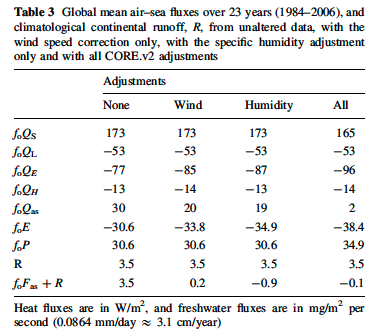

In [14]:
table_dir = base_repo_dir + '/references/Large_Yeager/images/tables/global_mean_air-sea_fluxes_table.png'
im = PIL.Image.open(table_dir)

im.show()

### Background of Large and Yeager CORE.v2 Coupled Ocean Sea-Ice Model Analysis

Table 3 contains global-mean air-sea heat flux property values over the time period of 1984-2006 over which there is partial overlap with the ECCOv4r4 time period of 1992-2017. According to Large and Yeager (2009), the procedure in the research study "utilizes an alternative approach to provide global estimates of all the air-sea fluxes that capture as much interannual variability as possible. In the process, a complete suite of flux parameters has been assembled, which can provide interannually varying forcing for ocean and sea-ice models, including CORE". According to Griffies et al. (2008), The "CORE" model framework is regarded as a coupled ocean-ice Coordinated Ocean Research Experiments model where air-sea fluxes are computed from prognostic SST. Incorporated into this framework is sub-daily wind resolution of the inertial period and storm events. 

Additionally, the fluxes are independent of ocean transport estimates as well as self-consistent. Large and Yeager (2009) summarize the procedure through which air-sea heat fluxes are obtained using CORE as, the "fluxes are computed from forcing data sets assembled by Large and Yeager (2004)" where "the key approach is to reduce known biases, by comparing to more accurate and reliable observations that are either too regional, or too short to be suitable themselves". The second version of the forcing data and the accompanying model from which CORE fluxes were computed,(the subject of the study by Large and Yeager (2009)), is denoted as "CORE.v2". All datasets rendered in tables and plots by Large and Yeager (2009) in this notebook will be from the CORE.v2 coupled ocean-ice model. 

In restricting attention to the global mean air-sea heat fluxes incorporating both wind and humidity adjustments, it is shown that the net shortwave (solar) radiation term has the positive largest contribution to the net heat flux with 165 W/m2 whereas the latent heat flux term has the largest negative (cooling) contribution to the net heat flux with a global mean of -96 W/m2 over this time period. The net longwave and latent heat fluxes have global mean negative (cooling) contributions of -14 and -53 W/m2 respectively.


More details regarding the researchers' procedures, assumptions, and analysis can be found in the articles whose citations are provided in the '/references/README.md' file.


### Comparison of ECCOv4r4 and CORE.v2 Global Mean Heat Flux Property Model Output

Although somewhat naive considering the differences in the presentation of the ECCOv4r4 and CORE.v2 net heat flux data, and the different time periods of model coverage (1992 - 2017 for the former, 1984 - 2006 for the latter), comparisons will be made between the models' approximate time mean global net heat flux properties. In comparing the time mean of the net shortwave radiative heat fluxes from the two models, a value of 165 W/m2 for the CORE.v2 output agrees very closely with a time mean of approximately 168 W/m2 for the ECCOv4r4 output. With respect to the net longwave radiative heat flux comparisons, there is a larger differential between the time mean from the two models with a mean of -53 W/m2 for the CORE.v2 model and approximately -45 W/m2 for the ECCOv4r4 model. It is reasonable that the time mean longwave radiative heat flux from the CORE.v2 model has a larger magnitude than that of the ECCOv4r4 model considering that the former covers an earlier time range when it is common knowledge that a smaller percentage of radiant energy penetrating the earth's surface was absorbed by the surface and thus converted into greenhouse gases that warmed the atmosphere at a smaller rate.

# FINISH

### QUESTIONS AND CONCERNS

1. What are the physical explanations for the increase in the magnitude of the time-mean global net latent and sensible heat fluxes? Can the explanation for the former be that there has been an increase in the quantity and intensity of phase changes in air-sea-ice interactions in high latitudes where thermal energy loss from sea-ice to atmosphere has increased over time? I'm assuming that the primary explanation for the increase in the magnitude of the sensible heat flux over time is an increase in the mean temperature differential between the global ocean and atmosphere but what underlying factors are at play here? 

## Render Net Heat Flux and Net Heat Flux Residual Time-Series Plots for ECCOv4r4 Model Output

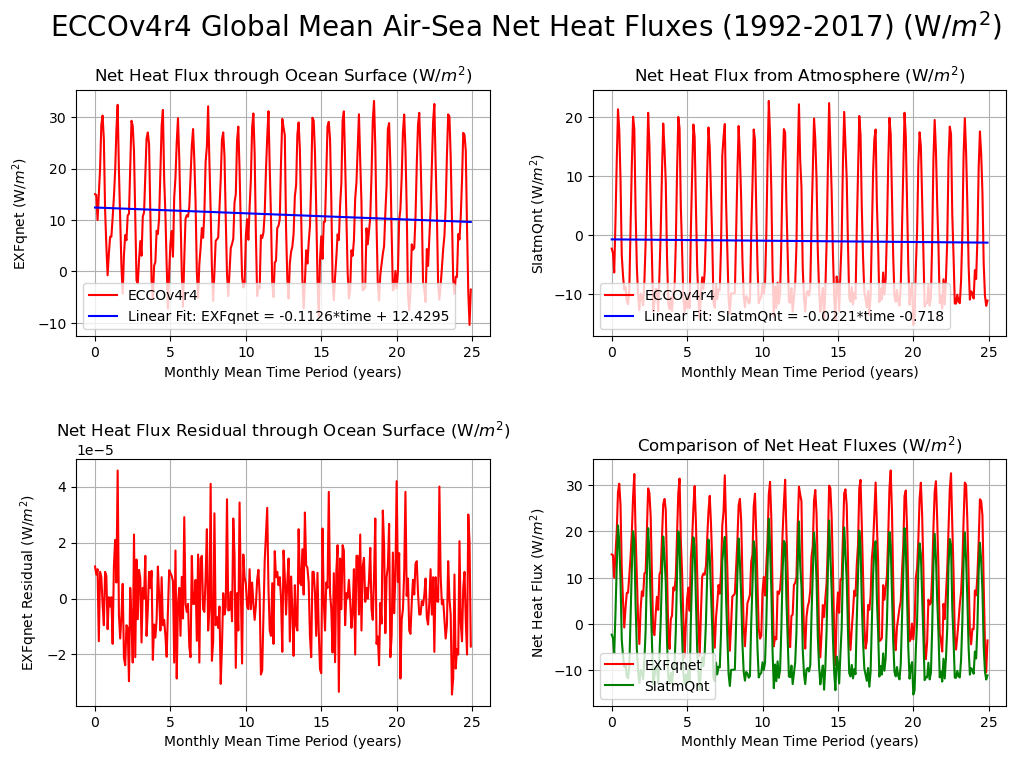

<Figure size 640x480 with 0 Axes>

In [15]:
# Initiailize figure geometry with four subplot grids for net heat flux visualizations

fig, axs = plt.subplots(2, 2, figsize = (12,8))
axs = axs.flatten()

# ######## Time Series of Globally-Integrated, Area-Weighted Mean Net Heat Flux due to sea-ice- 
# ######## ocean surface transfer (atmosphere to ocean surface transfer in 
# ######## areas without ice cover)

plt.sca(axs[0])
axs[0].plot(time, EXFqnet_area_weighted_np,color='r')

# Fit Linear Regression Model to EXFqnet Time-Series Data

m, b = np.polyfit(time, EXFqnet_area_weighted_np, 1) 
m_r = round(m, 4)
b_r = round(b, 4)

# Render Linear Best Fit Line Plot 

axs[0].plot(time, m*time + b, 'b')
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel('EXFqnet (W/$m^{2}$)');
plt.legend(['ECCOv4r4', 'Linear Fit: EXFqnet = ' + str(m_r) + \
            '*' + 'time + ' + str(b_r)]);
plt.title("Net Heat Flux through Ocean Surface (W/$m^{2}$)")
plt.grid()

######## Time Series of area-weighted mean Net Heat Flux due to atmosphere-sea-ice transfer 

plt.sca(axs[1])
axs[1].plot(time, SIatmQnt_area_weighted, color='r')

# Fit Linear Regression Model to EXFqnet Time-Series Data

m, b = np.polyfit(time, SIatmQnt_area_weighted_np, 1) 
m_r = round(m, 4)
b_r = round(b, 4)

# Render Linear Best Fit Line Plot 

axs[1].plot(time, m*time + b, 'b')
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel('SIatmQnt (W/$m^{2}$)');
plt.legend(['ECCOv4r4', 'Linear Fit: SIatmQnt = ' + str(m_r) + \
            '*' + 'time ' + str(b_r)], loc = 'lower left');
plt.title("Net Heat Flux from Atmosphere (W/$m^{2}$)")
plt.grid()

######## Heat Flux Residual due to Sea-Ice-Ocean Surface Transfer
######## (EXFqnet - (-EXFhl - EXFhs + EXFswnet + EXFlwnet))

plt.sca(axs[2])
axs[2].plot(time, EXFqnet_residual_area_weighted_np,color='r')
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel('EXFqnet Residual (W/$m^{2}$)');
plt.title("Net Heat Flux Residual through Ocean Surface (W/$m^{2}$)")
plt.grid()

# Comparison of Net Heat Flux due to Sea-Ice-Ocean Surface Transfer 
# to Net Heat Flux due to Sea-Ice-Ocean Surface Transfer 

plt.sca(axs[3])
axs[3].plot(time, EXFqnet_area_weighted_np, color = 'r')
axs[3].plot(time, SIatmQnt_area_weighted_np,color='g')
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel('Net Heat Flux (W/$m^{2}$)');
plt.title("Comparison of Net Heat Fluxes (W/$m^{2}$)")
plt.legend(['EXFqnet', 'SIatmQnt'], loc = 'lower left')
plt.grid()

# Render figure title

plt.subplots_adjust(hspace = 0.5, wspace=.25)
plt.suptitle('ECCOv4r4 Global Mean Air-Sea Net Heat Fluxes (1992-2017) (W/$m^{2}$)',
                 fontsize=20);
plt.show();

# Save figure to local file system as '.png'

plt.savefig(output_dir + '/global_mean_eccov4r4_air_sea_net_heat_fluxes.png')

## Procedure and Analysis of Global Mean Net Heat Flux Time-Series Plots for ECCOv4r4 Model Output

### Procedure Summary

1. The monthly-mean net air-sea heat fluxes from the ECCOv4r4 model datasets (spanning a time period of 1992-2017), were read into a single 'xarray.Dataset' object
2. Then, redundant coordinates were dropped from both objects to reduce the workspace's memory footprint.
3. From here, the 'xarray.DataArray' objects corresponding to the individual net air-sea heat flux terms were indexed from the 'xarray.Dataset' object and assigned to individual variables
4. Then, the globally-integrated, area-weighted mean (horizontal spatially-averaged, area-weighted mean) heat flux values were obtained for each month in the time period using the 'masked area array' and 'xgcm grid object'.
5. Next, the arrays were converted into 'numpy.ndarray' objects to enable rendering of the data using matplotlib plotting routines
6. Then, a figure with time-series line plots of the air-sea heat flux at the sea surface was rendered as shown above, and linear regression was used to fit a first degree polynomial equation to the applicable data sets as before.
7. Lastly, the figure was saved to the local filesystem.

### Analysis of Results

The figure above presents four subplots depicting net air-sea heat flux time-series trends for the ECCOv4r4 model output over the time period of 1992 - 2017. In referencing the first subplot, it is shown that there is an approximately sinusoidal relationship between the global mean net heat flux through the ocean surface and time with each annual time period in the domain exhibiting very similar behavior. To expand, the global mean net heat flux is approximately at a minimum at the beginning and very end of the calendar year (January and December respectively), and a maximum at the middle of the calendar year (June).


#### Incorporate feedback from question 2 for subplot 2 explanation


In referencing the third subplot, through residual plot values that are on the order of magnitude of 1e-5, it is evident that the ECCOv4r4 model output's net heat flux through the ocean surface dataset (EXFqnet) is approximated very well by the linear combination of the following datasets: sensible heat flux into the ocean, latent heat flux into the ocean, net longwave radiative heat flux, and net shortwave radiative heat flux.

Looking at the fourth suplot, it is shown that the sinusoidal periodic relationship from the global mean net heat flux into the ocean surface (EXFqnet) whose shape is approximately preserved from year to year is nearly mirrored by that of the global mean neat heat flux from the atmosphere (SIatmQnt) with the difference lying in troughs and amplitudes for the latter that are consistently smaller than the former. An important distinction between the two global mean net heat fluxes is that EXFqnet corresponds to the net heat flux from the atmosphere to the ocean surface in areas without ice cover and the net heat flux from the sea-ice to the ocean surface in areas with ice cover whereas SIatmQnt corresponds to the net heat flux from the atmosphere to the ocean surface in areas without ice cover and from the atmosphere to the sea-ice in areas with ice cover. 

#### To finish explanation for fourth subplot, incorporate feedback from question 3


#### FINISH

#### Questions and Concerns

1. Why does the global mean net heat flux tend towards a minimum at the beginning of the year when most of the surface ocean (i.e. in the southern hemisphere) is in peak summer season with warmer atmosphere and sea surface temperatures and a maximum during the middle of the year when this same regional domain is in peak winter season with cold temperatures? What is the physical explanation behind why it is not the other way around?
2. Same question for the global mean net heat flux from atmosphere to sea-ice
3. What is the reasoning behind why the global mean net heat flux from the atmosphere (SIatmQnt) is consistently lower than the global mean net heat flux into the ocean (EXFQnt) over this time period?


## Analysis of Ocean Basin Mean Net Air-Sea Flux for ECCOv4r4 Model Output

### Wrangling of Ocean Basin Mean Net Air-Sea Flux Data for ECCOv4r4 Model Output

In [16]:
# Merge the xarray grid dataset object with xarray freshwater flux dataset object
# for more efficient operations that link flux properties to grid locations

air_sea_flux_ds_merged = xr.merge((ecco_v4r4_grid, freshwater_flux_monthly_mean_ds, \
                                  heat_flux_monthly_mean_ds))

# Define directory path to 'basins.meta' and 'basins.data' files for basin partitioning
data_dir = '/scratch2/jcam98/CRIOS/ECCO_analysis_work/datasets/v4r4/original_output/grid_params'

# Define array for masking air-sea flux values 

maskC = air_sea_flux_ds_merged.maskC

######### Mask air-sea flux values by applicable ocean basins ###########

pac_maskC = ecco.get_basin_mask(basin_name = 'pacExt', mask = maskC, basin_path = \
                               data_dir);
atl_maskC = ecco.get_basin_mask(basin_name = 'atlExt', mask = maskC, basin_path = \
                               data_dir);
ind_maskC = ecco.get_basin_mask(basin_name = 'indExt', mask = maskC, basin_path = \
                               data_dir);

get_basin_name:  ['pac', 'bering', 'okhotsk', 'japan', 'eastChina'] /scratch2/jcam98/CRIOS/ECCO_analysis_work/datasets/v4r4/original_output/grid_params
load_binary_array: loading file /scratch2/jcam98/CRIOS/ECCO_analysis_work/datasets/v4r4/original_output/grid_params/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
get_basin_name:  ['atl', 'mexico', 'hudson', 'med', 'north', 'baffin', 'gin'] /scratch2/jcam98/CRIOS/ECCO_analysis_work/datasets/v4r4/original_output/grid_params
load_binary_array: loading file /scratch2/jcam98/CRIOS/ECCO_analysis_work/datasets/v4r4/original_output/grid_params/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, l

### Southern Ocean Basin Interpretation

Define Southern Ocean Basin as encompassing latitudes south of -30 N latitude and between -180 and 180 E longitude. This approximation to the Southern Ocean Basin corresponds to a domain that includes areas of the ECCOv4r4's southern-most broad Pacific, Atlantic, and Indian basins and is the most widely-accepted Southern Ocean basin.

In [17]:
# Apply applicable ocean basin masks to freshwater flux (minus runoff) and heat flux data

emp_pac_maskC = (air_sea_flux_ds_merged.EXFempmr - air_sea_flux_ds_merged.EXFroff) * pac_maskC
emp_atl_maskC = (air_sea_flux_ds_merged.EXFempmr - air_sea_flux_ds_merged.EXFroff) * atl_maskC
emp_ind_maskC = (air_sea_flux_ds_merged.EXFempmr - air_sea_flux_ds_merged.EXFroff) * ind_maskC
emp_global = (air_sea_flux_ds_merged.EXFempmr - air_sea_flux_ds_merged.EXFroff)
exfqnt_pac_maskC = air_sea_flux_ds_merged.EXFqnet * pac_maskC
exfqnt_atl_maskC = air_sea_flux_ds_merged.EXFqnet * atl_maskC
exfqnt_ind_maskC = air_sea_flux_ds_merged.EXFqnet * ind_maskC
exfqnt_global = air_sea_flux_ds_merged.EXFqnet

# Index values at sea surface 

emp_pac_maskC = emp_pac_maskC.isel(k = 0)
emp_atl_maskC = emp_atl_maskC.isel(k = 0)
emp_ind_maskC = emp_ind_maskC.isel(k = 0)
exfqnt_pac_maskC = exfqnt_pac_maskC.isel(k = 0)
exfqnt_atl_maskC = exfqnt_atl_maskC.isel(k = 0)
exfqnt_ind_maskC = exfqnt_ind_maskC.isel(k = 0)

# Initialize variables for storing southern ocean masks

emp_sou_maskC = (air_sea_flux_ds_merged.EXFempmr - air_sea_flux_ds_merged.EXFroff) + 0
exfqnt_sou_maskC = exfqnt_global + 0

# Convert freshwater flux values from units of (m/s) to (mg/m2*s)

rho_fresh = 1000 # freshwater density set to 1000 kg/m3
kg_to_mg = 1000 # kilogram to milligram conversion factor

emp_pac_maskC = emp_pac_maskC * rho_fresh * kg_to_mg
emp_atl_maskC = emp_atl_maskC * rho_fresh * kg_to_mg
emp_ind_maskC = emp_ind_maskC * rho_fresh * kg_to_mg
emp_sou_maskC = emp_sou_maskC * rho_fresh * kg_to_mg
emp_global = emp_global * rho_fresh * kg_to_mg

# Index Southern Ocean basin between 30S and 90 S latitude

lat_bounds = np.logical_and(emp_sou_maskC.YC >= -90, emp_sou_maskC.YC <= -30)
lon_bounds = np.logical_and(emp_sou_maskC.XC >= -180, emp_sou_maskC.XC <= 180)
emp_sou_maskC = emp_sou_maskC.where(np.logical_and(lat_bounds, lon_bounds))
exfqnt_sou_maskC = exfqnt_sou_maskC.where(np.logical_and(lat_bounds, lon_bounds))

# Index Pacific, Atlantic, and Indian Ocean basins above 30S latitude

lat_bounds = np.logical_and(emp_pac_maskC.YC >= -30, emp_pac_maskC.YC <= 90)
lon_bounds = np.logical_and(emp_pac_maskC.XC >= -180, emp_pac_maskC.XC <= 180)
emp_pac_maskC = emp_pac_maskC.where(np.logical_and(lat_bounds, lon_bounds))
exfqnt_pac_maskC = exfqnt_pac_maskC.where(np.logical_and(lat_bounds, lon_bounds))
lat_bounds = np.logical_and(emp_atl_maskC.YC >= -30, emp_atl_maskC.YC <= 90)
lon_bounds = np.logical_and(emp_atl_maskC.XC >= -180, emp_atl_maskC.XC <= 180)
emp_atl_maskC = emp_atl_maskC.where(np.logical_and(lat_bounds, lon_bounds))
exfqnt_atl_maskC = exfqnt_atl_maskC.where(np.logical_and(lat_bounds, lon_bounds))
lat_bounds = np.logical_and(emp_ind_maskC.YC >= -30, emp_ind_maskC.YC <= 90)
lon_bounds = np.logical_and(emp_ind_maskC.XC >= -180, emp_ind_maskC.XC <= 180)
emp_ind_maskC = emp_ind_maskC.where(np.logical_and(lat_bounds, lon_bounds))
exfqnt_ind_maskC = exfqnt_ind_maskC.where(np.logical_and(lat_bounds, lon_bounds))

### Mask Grid Cell Sea Surface Area by Surface Area Covered in Seawater and by Applicable Ocean Basins

In [18]:
# Mask grid cell sea surface area by applicable ocean basins

area_masked_pac = emp_pac_maskC.rA.values
area_masked_atl = emp_atl_maskC.rA.values
area_masked_ind = emp_ind_maskC.rA.values
area_masked_sou = emp_sou_maskC.rA.values

In [19]:
emp_pac_maskC

<xarray.DataArray (time: 300, tile: 13, j: 90, i: 90)>
dask.array<where, shape=(300, 13, 90, 90), dtype=float64, chunksize=(1, 13, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (tile, j, i) float32 -111.6 -111.3 -110.9 ... -99.42 -105.6 -111.9
    YC       (tile, j, i) float32 -88.24 -88.38 -88.52 ... -88.03 -88.08 -88.1
    CS       (tile, j, i) float32 0.06158 0.06675 0.07293 ... -0.9854 -0.9984
    SN       (tile, j, i) float32 -0.9981 -0.9978 -0.9973 ... -0.1705 -0.05718
    Depth    (tile, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    rA       (tile, j, i) float32 3.623e+08 3.633e+08 ... 3.685e+08 3.611e+08
  * time     (time) datetime64[ns] 1992-01-16T12:00:00 ... 2016-12-16T12:00:00
    k        int64 0

In [73]:
emp_sou_maskC

<xarray.DataArray (time: 300, tile: 13, j: 90, i: 90)>
dask.array<where, shape=(300, 13, 90, 90), dtype=float32, chunksize=(1, 13, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (tile, j, i) float32 -111.6 -111.3 -110.9 ... -99.42 -105.6 -111.9
    YC       (tile, j, i) float32 -88.24 -88.38 -88.52 ... -88.03 -88.08 -88.1
    CS       (tile, j, i) float32 0.06158 0.06675 0.07293 ... -0.9854 -0.9984
    SN       (tile, j, i) float32 -0.9981 -0.9978 -0.9973 ... -0.1705 -0.05718
    Depth    (tile, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    rA       (tile, j, i) float32 3.623e+08 3.633e+08 ... 3.685e+08 3.611e+08
  * time     (time) datetime64[ns] 1992-01-16T12:00:00 ... 2016-12-16T12:00:00

### Evaluate Area-Weighted Horizontally-Averaged Freshwater Flux (Minus Runoff) and Heat Flux from ECCOv4r4 Model Output

In [20]:
emp_pac_basin_weighted_mean = ((emp_pac_maskC * area_masked_pac).sum(\
                          dim = ('i', 'j', 'tile'))) \
                        /((area_masked_pac.sum()))
emp_atl_basin_weighted_mean = ((emp_atl_maskC * area_masked_atl).sum(\
                          dim = ('i', 'j', 'tile'))) \
                        /((area_masked_atl.sum()))
emp_ind_basin_weighted_mean = ((emp_ind_maskC * area_masked_ind).sum(\
                          dim = ('i', 'j', 'tile'))) \
                        /((area_masked_ind.sum()))
emp_sou_basin_weighted_mean = ((emp_sou_maskC * area_masked_sou).sum(\
                          dim = ('i', 'j', 'tile'))) \
                        /((area_masked_sou.sum()))
emp_global_weighted_mean = ((emp_global * area_masked).sum(\
                          dim = ('i', 'j', 'tile'))) \
                        /((area_masked.sum()))

exfqnt_pac_basin_weighted_mean = ((exfqnt_pac_maskC * area_masked_pac).sum(\
                          dim = ('i', 'j', 'tile'))) \
                        /((area_masked_pac.sum()))
exfqnt_atl_basin_weighted_mean = ((exfqnt_atl_maskC * area_masked_atl).sum(\
                          dim = ('i', 'j', 'tile'))) \
                        /((area_masked_atl.sum()))
exfqnt_ind_basin_weighted_mean = ((exfqnt_ind_maskC * area_masked_ind).sum(\
                          dim = ('i', 'j', 'tile'))) \
                        /((area_masked_ind.sum()))
exfqnt_sou_basin_weighted_mean = ((exfqnt_sou_maskC * area_masked_sou).sum(\
                          dim = ('i', 'j', 'tile'))) \
                        /((area_masked_sou.sum()))
exfqnt_global_weighted_mean = ((exfqnt_global * area_masked).sum(\
                          dim = ('i', 'j', 'tile'))) \
                        /((area_masked.sum()))

# Convert DataArray objects into numpy arrays for plotting

emp_pac_basin_weighted_mean_np = np.array(emp_pac_basin_weighted_mean)
emp_atl_basin_weighted_mean_np = np.array(emp_atl_basin_weighted_mean)
emp_ind_basin_weighted_mean_np = np.array(emp_ind_basin_weighted_mean)
emp_sou_basin_weighted_mean_np = np.array(emp_sou_basin_weighted_mean)
emp_global_weighted_mean_np = np.array(emp_global_weighted_mean)
exfqnt_pac_basin_weighted_mean_np = np.array(exfqnt_pac_basin_weighted_mean)
exfqnt_atl_basin_weighted_mean_np = np.array(exfqnt_atl_basin_weighted_mean)
exfqnt_ind_basin_weighted_mean_np = np.array(exfqnt_ind_basin_weighted_mean)
exfqnt_sou_basin_weighted_mean_np = np.array(exfqnt_sou_basin_weighted_mean)
exfqnt_global_weighted_mean_np = np.array(exfqnt_global_weighted_mean)

### Render Ocean Basin Mean Net Freshwater Flux (Minus Runoff) and Heat Flux Time-Series Plot for ECCOv4r4 Model Output

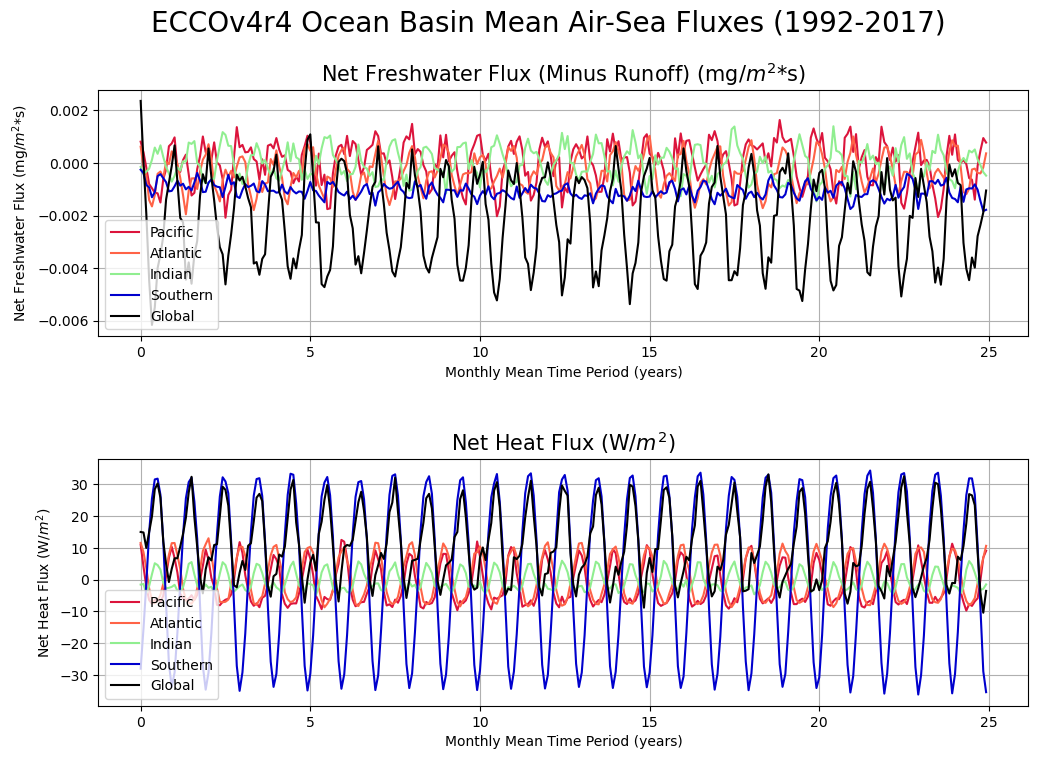

<Figure size 640x480 with 0 Axes>

In [21]:
# Render Line Plots of Ocean Basin and Global Mean Freshwater and Heat Fluxes

fig, axs = plt.subplots(2, 1, figsize = (12,8))

plt.sca(axs[0]);
axs[0].plot(time, emp_pac_basin_weighted_mean_np, '#DC143C')
axs[0].plot(time, emp_atl_basin_weighted_mean_np, '#FF6347')
axs[0].plot(time, emp_ind_basin_weighted_mean_np, '#90EE90')
axs[0].plot(time, emp_sou_basin_weighted_mean_np,'#0000CD')
axs[0].plot(time, emp_global_weighted_mean_np, 'k')

plt.xlabel('Monthly Mean Time Period (years)');
plt.ylabel('Net Freshwater Flux (mg/$m^{2}$*s)');
axs[0].legend(['Pacific', 'Atlantic', 'Indian', 'Southern', 'Global']);

plt.title('Net Freshwater Flux (Minus Runoff) (mg/$m^{2}$*s)',
                 fontsize=15);
plt.grid();

plt.sca(axs[1]);
axs[1].plot(time, exfqnt_pac_basin_weighted_mean_np, color= '#DC143C')
axs[1].plot(time, exfqnt_atl_basin_weighted_mean_np, color='#FF6347')
axs[1].plot(time, exfqnt_ind_basin_weighted_mean_np, color= '#90EE90')
axs[1].plot(time, exfqnt_sou_basin_weighted_mean_np, color= '#0000CD')
axs[1].plot(time, exfqnt_global_weighted_mean_np, color = 'k')

plt.xlabel('Monthly Mean Time Period (years)');
plt.ylabel('Net Heat Flux (W/$m^{2}$)');
plt.legend(['Pacific', 'Atlantic', 'Indian', 'Southern', 'Global']);
plt.title('Net Heat Flux (W/$m^{2}$)',
                 fontsize=15);
plt.grid();

# Render figure title
plt.subplots_adjust(hspace = 0.5, wspace=.25)
plt.suptitle('ECCOv4r4 Ocean Basin Mean Air-Sea Fluxes (1992-2017)',
                 fontsize=20);

plt.show();

# Save figure to local file system as '.png'

plt.savefig(output_dir + '/basin_mean_eccov4r4_air_sea_fluxes.png')

### Procedure and Analysis of Ocean Basin Mean Air-Sea Flux Time-Series Plots for ECCOv4r4 Model Output

### Procedure Summary

1. First, the dataset object containing the ECCOv4r4 model grid geometry was merged with datasets containing the air-sea freshwater and heat flux values
2. From here, the numpy array containing the c-grid point values needed to mask the flux values was extracted from the merged dataset object and used to define an individual masked array for each ocean basin. 
3. From here, the ocean basin masks were applied to the net heat flux and net freshwater flux (minus runoff) datasets.
4. Next, the freshwater flux values were converted from units of (m/s) to (mg/m2*s) to be dimensionally-consistent with that of the freshwater flux units in CORE.v2 dataset.
5. Then, the grid cell surface areas were masked by the area covered in seawater and by applicable ocean basins.
6. From here, the area-weighted horizontally-spatially-averaged mean flux values were evaluated for each ocean basin and converted into numpy arrays.
7. The ocean basins plots were then rendered on two subplots on a single figure.
8. Lastly, the figure was saved to the local filesystem.

### Analysis of Results

### Questions and Concerns

1. Run through the procedures for both subplots to determine root cause of discrepancy in trends between ECCOv4r4 plots and CORE.v2 plots for the net freshwater flux (minus) runoff as the eccov4r4 trends are orders of magnitude smaller. The order of magnitude of the net heat flux trends are comparable however, there is significant overlap between all of the trends which is in stark contrast to the consistency in mean freshwater flux within ocean basins depicted in the corev2 trends over the same time period.

FINISH


## Analysis of Global Mean Freshwater Flux for ECCOv4r4 Model Output

### Wrangling of Global Mean Net Freshwater Flux Data

In [22]:
######### For Global Mean Net Freshwater Flux Datasets ############

# Extract xarray.DataArray objects corresponding to each surface freshwater
# flux property in dataset (Negate 'EXFempmr' array so that positive values correspond 
# to net increase in freshwater flux into ocean not atmosphere). These values will be used
# for global mean property visualizations

EXFempmr_arr = -freshwater_flux_monthly_mean_ds.EXFempmr 
EXFevap_arr = freshwater_flux_monthly_mean_ds.EXFevap
EXFroff_arr = freshwater_flux_monthly_mean_ds.EXFroff
EXFpreci_arr = freshwater_flux_monthly_mean_ds.EXFpreci
SIatmFW_arr = freshwater_flux_monthly_mean_ds.SIatmFW

# Convert surface freshwater flux (EXF) values from (m/s) to (mm/year) to be consistent 
# with monthly mean data

EXFempmr_arr = EXFempmr_arr * (365.25 * 24 * 60 * 60 * 1000)
EXFevap_arr = EXFevap_arr * (365.25 * 24 * 60 * 60 * 1000)
EXFroff_arr = EXFroff_arr * (365.25 * 24 * 60 * 60 * 1000)
EXFpreci_arr = EXFpreci_arr * (365.25 * 24 * 60 * 60 * 1000)

# Convert net freshwater flux from atmosphere to sea-ice (SIatmFW_arr) from (kg/(m2 * s))
#to (mm/year)

rho_fresh = 1000 # freshwater density in (kg/m3)
SIatmFW_arr = SIatmFW_arr * (1/rho_fresh) * (365.25 * 24 * 60 * 60 * 1000)

### Evaluate Area-Weighted, Horizontally-Averaged Freshwater Flux Properties from ECCOv4r4 Model Output

In [23]:
# Evaluate horizontally-integrated, area-weighted mean of surface freshwater 
# flux properties to obtain one resultant mean value for each month in time period

EXFempmr_area_weighted = (EXFempmr_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

EXFevap_area_weighted = (EXFevap_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

EXFroff_area_weighted = (EXFroff_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

EXFpreci_area_weighted = (EXFpreci_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

SIatmFW_area_weighted = (SIatmFW_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

EXFempmr_residual_area_weighted = EXFempmr_area_weighted - (EXFevap_area_weighted - \
                                 EXFroff_area_weighted - EXFpreci_area_weighted)

### Render Freshwater Flux Property Time-Series Plots for ECCOv4r4 Model Output (mm/year)

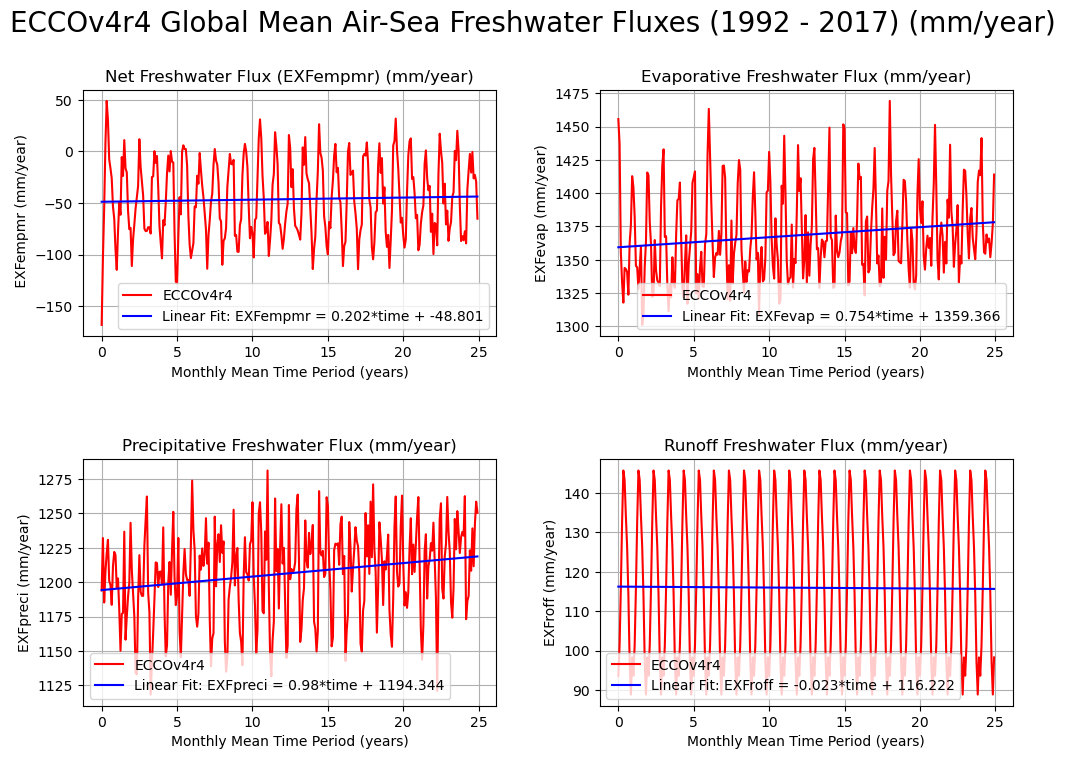

<Figure size 640x480 with 0 Axes>

In [24]:
# Convert xarray.DataArray objects storing freshwater flux property values into numpy arrays
# for linear regression model fitting

EXFempmr_area_weighted_np = np.array(EXFempmr_area_weighted)
EXFevap_area_weighted_np = np.array(EXFevap_area_weighted)
EXFroff_area_weighted_np = np.array(EXFroff_area_weighted)
EXFpreci_area_weighted_np = np.array(EXFpreci_area_weighted)

# Initialize figure geometry with four subplot grids for freshwater flux property visualizations

fig, axs = plt.subplots(2, 2, figsize = (12,8))
axs = axs.flatten()

######## Time Series of Globally-integrated, Area-Weighted Mean Net Freshwater Flux due to
######## sea-ice-ocean surface transfer (atmosphere to ocean surface transfer in areas without
######## ice cover)

plt.sca(axs[0])
axs[0].plot(time, EXFempmr_area_weighted_np,color='r')

# Fit Linear Regression Model to EXFempmr Time-Series Data

m, b = np.polyfit(time, EXFempmr_area_weighted_np, 1) 
m_r = round(m, 3)
b_r = round(b, 3)

# Render Linear Best Fit Line Plot 

axs[0].plot(time, m*time + b, 'b')
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel(' EXFempmr (mm/year)');
plt.legend(['ECCOv4r4', 'Linear Fit: EXFempmr = ' + str(m_r) + \
            '*' + 'time + ' + str(b_r)]);
plt.title("Net Freshwater Flux (EXFempmr) (mm/year)")
plt.grid()

######## Time Series of Evaporative Freshwater Flux 

plt.sca(axs[1])
axs[1].plot(time, EXFevap_area_weighted,color='r')

# Fit Linear Regression Model to EXFevap Time-Series Data

m, b = np.polyfit(time, EXFevap_area_weighted_np, 1) 
m_r = round(m, 3)
b_r = round(b, 3)

# Render Linear Best Fit Line Plot 

axs[1].plot(time, m*time + b, 'b')
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel('EXFevap (mm/year)');
plt.legend(['ECCOv4r4', 'Linear Fit: EXFevap = ' + str(m_r) + \
            '*' + 'time + ' + str(b_r)], loc = 'lower right');
plt.title("Evaporative Freshwater Flux (mm/year)")
plt.grid()

######### Time Series of Precipitative Freshwater Flux 

plt.sca(axs[2])
axs[2].plot(time, EXFpreci_area_weighted_np,color='r')
            
# Fit Linear Regression Model to EXFpreci Time-Series Data

m, b = np.polyfit(time, EXFpreci_area_weighted_np, 1) 
m_r = round(m, 3)
b_r = round(b, 3)

# Render Linear Best Fit Line Plot 

axs[2].plot(time, m*time + b, 'b')
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel('EXFpreci (mm/year)');
plt.legend(['ECCOv4r4', 'Linear Fit: EXFpreci = ' + str(m_r) + \
            '*' + 'time + ' + str(b_r)]);
plt.title("Precipitative Freshwater Flux (mm/year)")
plt.grid()

######## Time Series of Runoff Freshwater Flux 

plt.sca(axs[3])
axs[3].plot(time, EXFroff_area_weighted_np,color='r')
            
# Fit Linear Regression Model to EXFroff Time-Series Data

m, b = np.polyfit(time, EXFroff_area_weighted_np, 1) 
m_r = round(m, 3)
b_r = round(b, 3)

# Render Linear Best Fit Line Plot 

axs[3].plot(time, m*time + b, 'b')
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel('EXFroff (mm/year)');
plt.legend(['ECCOv4r4', 'Linear Fit: EXFroff = ' + str(m_r) + \
            '*' + 'time + ' + str(b_r)], loc = 'lower left');
plt.title("Runoff Freshwater Flux (mm/year)")
plt.grid()

# Render figure title
plt.subplots_adjust(hspace = 0.5, wspace=.25)
plt.suptitle('ECCOv4r4 Global Mean Air-Sea Freshwater Fluxes (1992 - 2017) (mm/year)',
                 fontsize=20);
plt.show();

# Save figure to local file system as '.png'

plt.savefig(output_dir + '/global_mean_eccov4r4_air_sea_freshwater_fluxes_mm_year.png')


### Render Freshwater Flux Property Time-Series Plots for ECCOv4r4 Model Output (mg/m2*s)

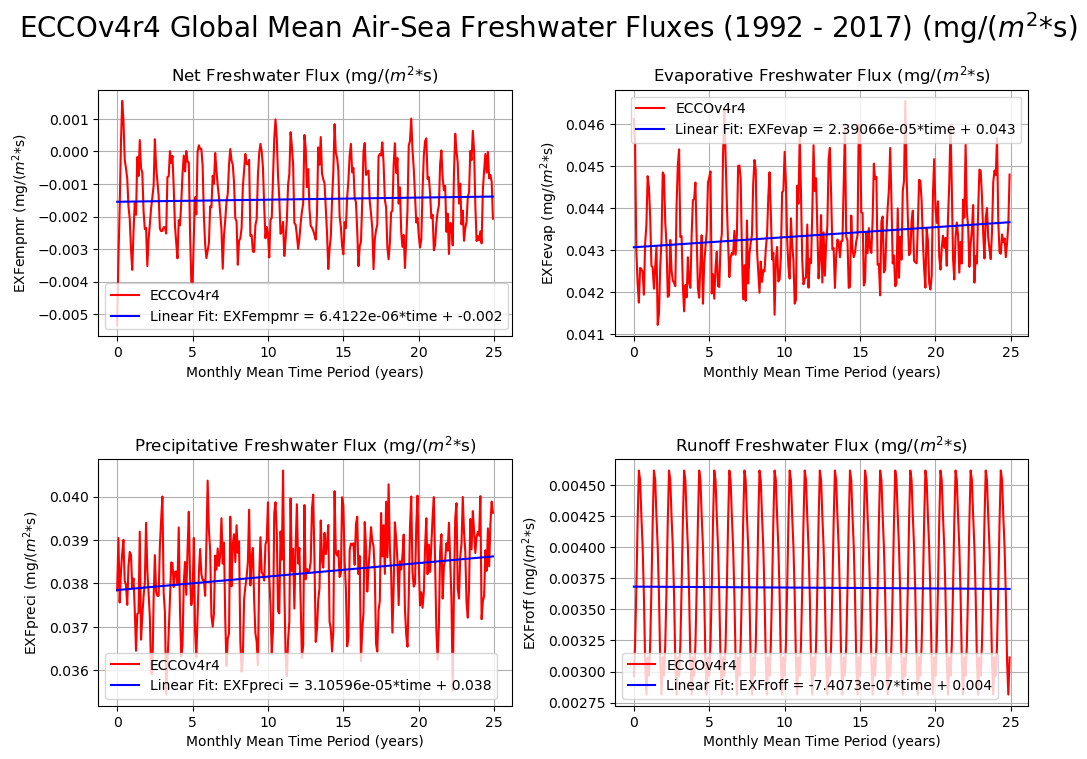

The time mean of global evaporative freshwater flux is 0.043373533 mg/m2*s
The time mean of global precipitative freshwater flux is 0.038233414 mg/m2*s
The time mean of global freshwater runoff flux is 0.0036736103 mg/m2*s


<Figure size 640x480 with 0 Axes>

In [25]:
# Convert freshwater flux measurements from (mm/year) to (mg/m2*s)

EXFempmr_area_weighted_np_2 = EXFempmr_area_weighted_np * 1000 / (365.25 * 24 * 60 * 60)
EXFevap_area_weighted_np_2 = EXFevap_area_weighted_np  * 1000 / (365.25 * 24 * 60 * 60)
EXFroff_area_weighted_np_2 = EXFroff_area_weighted_np  * 1000 / (365.25 * 24 * 60 * 60)
EXFpreci_area_weighted_np_2 = EXFpreci_area_weighted_np * 1000 / (365.25 * 24 * 60 * 60)

# Initialize figure geometry with four subplot grids for freshwater flux property visualizations

fig, axs = plt.subplots(2, 2, figsize = (12,8))
axs = axs.flatten()

######## Time Series of Globally-integrated, Area-Weighted Mean Net Freshwater Flux due to
######## sea-ice-ocean surface transfer (atmosphere to ocean surface transfer in areas without
######## ice cover)

plt.sca(axs[0])
axs[0].plot(time, EXFempmr_area_weighted_np_2,color='r')

# Fit Linear Regression Model to EXFempmr Time-Series Data

m, b = np.polyfit(time, EXFempmr_area_weighted_np_2, 1) 
m_r = round(m, 10)
b_r = round(b, 3)

# Render Linear Best Fit Line Plot 

axs[0].plot(time, m*time + b, 'b')
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel('EXFempmr (mg/($m^{2}$*s)');
plt.legend(['ECCOv4r4', 'Linear Fit: EXFempmr = ' + str(m_r) + \
            '*' + 'time + ' + str(b_r)]);
plt.title("Net Freshwater Flux (mg/($m^{2}$*s)")
plt.grid()

######## Time Series of Evaporative Freshwater Flux 

plt.sca(axs[1])
axs[1].plot(time, EXFevap_area_weighted_np_2,color='r')

# Fit Linear Regression Model to EXFevap Time-Series Data

m, b = np.polyfit(time, EXFevap_area_weighted_np_2, 1) 
m_r = round(m, 10)
b_r = round(b, 3)

# Render Linear Best Fit Line Plot 

axs[1].plot(time, m*time + b, 'b')
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel('EXFevap (mg/($m^{2}$*s)');
plt.legend(['ECCOv4r4', 'Linear Fit: EXFevap = ' + str(m_r) + \
            '*' + 'time + ' + str(b_r)]);
plt.title("Evaporative Freshwater Flux (mg/($m^{2}$*s)")
plt.grid()

# ######## Time Series of Precipitative Freshwater Flux 

plt.sca(axs[2])
axs[2].plot(time, EXFpreci_area_weighted_np_2,color='r')
            
# Fit Linear Regression Model to EXFpreci Time-Series Data

m, b = np.polyfit(time, EXFpreci_area_weighted_np_2, 1) 
m_r = round(m, 10)
b_r = round(b, 3)

# Render Linear Best Fit Line Plot 

axs[2].plot(time, m*time + b, 'b')
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel('EXFpreci (mg/($m^{2}$*s)');
plt.legend(['ECCOv4r4', 'Linear Fit: EXFpreci = ' + str(m_r) + \
            '*' + 'time + ' + str(b_r)]);
plt.title("Precipitative Freshwater Flux (mg/($m^{2}$*s)")
plt.grid()

######## Time Series of Runoff Freshwater Flux 

plt.sca(axs[3])
axs[3].plot(time, EXFroff_area_weighted_np_2,color='r')
            
# Fit Linear Regression Model to EXFroff Time-Series Data

m, b = np.polyfit(time, EXFroff_area_weighted_np_2, 1) 
m_r = round(m, 11)
b_r = round(b, 3)

# Render Linear Best Fit Line Plot 

axs[3].plot(time, m*time + b, 'b')
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel('EXFroff (mg/($m^{2}$*s)');
plt.legend(['ECCOv4r4', 'Linear Fit: EXFroff = ' + str(m_r) + \
            '*' + 'time + ' + str(b_r)], loc = 'lower left');
plt.title("Runoff Freshwater Flux (mg/($m^{2}$*s)")
plt.grid()

# Render figure title
plt.subplots_adjust(hspace = 0.5, wspace=.25)
plt.suptitle('ECCOv4r4 Global Mean Air-Sea Freshwater Fluxes (1992 - 2017) (mg/($m^{2}$*s)',
                 fontsize=20);
plt.show();

# Save figure to local file system as '.png'

plt.savefig(output_dir + '/global_mean_eccov4r4_air_sea_freshwater_fluxes_mg_m2_s.png')

# Compute time mean global freshwater flux property values

EXFevap_time_mean = np.mean(EXFevap_area_weighted_np_2)
EXFpreci_time_mean = np.mean(EXFpreci_area_weighted_np_2)
EXFroff_time_mean = np.mean(EXFroff_area_weighted_np_2)
print('The time mean of global evaporative freshwater flux is ' + str(EXFevap_time_mean) + ' mg/m2*s')
print('The time mean of global precipitative freshwater flux is ' + str(EXFpreci_time_mean) + ' mg/m2*s')
print('The time mean of global freshwater runoff flux is ' + str(EXFroff_time_mean) + ' mg/m2*s')

### Procedure and Analysis of Freshwater Flux Property Time-Series Plots for ECCOv4r4 Model Output

### Procedure Summary

1. The monthly-mean air-sea freshwater flux property values from the ECCOv4r4 model datasets (spanning a time period of 1992-2017), were read into a single 'xarray.Dataset' object
2. Then, redundant coordinates were dropped from both objects to reduce the workspace's memory footprint.
3. From here, the 'xarray.DataArray' objects corresponding to the individual air-sea freshwater flux terms were indexed from the 'xarray.Dataset' object and assigned to individual variables
4. Then, the globally-integrated, area-weighted mean (horizontal spatially-averaged, area-weighted mean) freshwater flux values were obtained for each month in the time period using the 'masked area array' and 'xgcm grid object'.
5. A copy of each of the resultant arrays was made and for the copy, the values were multiplied by the freshwater fluid density of 1000kg/m3 and the units were rescaled to match those of the freshwater flux values rendered from the CORE.v2 dataset (mg/m2*s). 
6. Next, the arrays were converted into 'numpy.ndarray' objects to enable rendering of the data using matplotlib plotting routines
7. Then, two figures with time-series line plots of the air-sea freshwater flux at the sea surface were rendered as shown above, and linear regression was used to fit a first degree polynomial equation to the applicable data sets as before.
8. Lastly, the figures was saved to the local filesystem.

### Analysis of Results


FINISH

### Questions and Concerns

1. Run through time-series patterns of all eight plots and receive feedback regarding comparison to expected patterns.
2. Confirm the order of magnitude is as expected?


### Comparison of ECCOv4r4 and CORE.v2 Global Mean Freshwater Flux Property Values

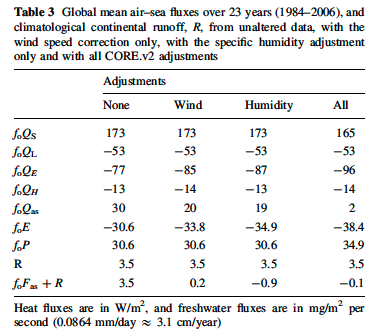

In [26]:
# Render global mean freshwater flux values from CORE.v2 

table_dir = base_repo_dir + '/references/Large_Yeager/images/tables/global_mean_air-sea_fluxes_table.png'
im = PIL.Image.open(table_dir)

im.show()

# FINISH

### QUESTIONS AND CONCERNS

1. Troubleshoot the four orders of magnitude difference between the CORE.v2 time-mean freshwater flux values and the ECCOvr4 time-mean flux values

### Render Net Freshwater Flux and Net Freshwater Flux Residual Time-Series Plots for ECCOv4r4 Model Output

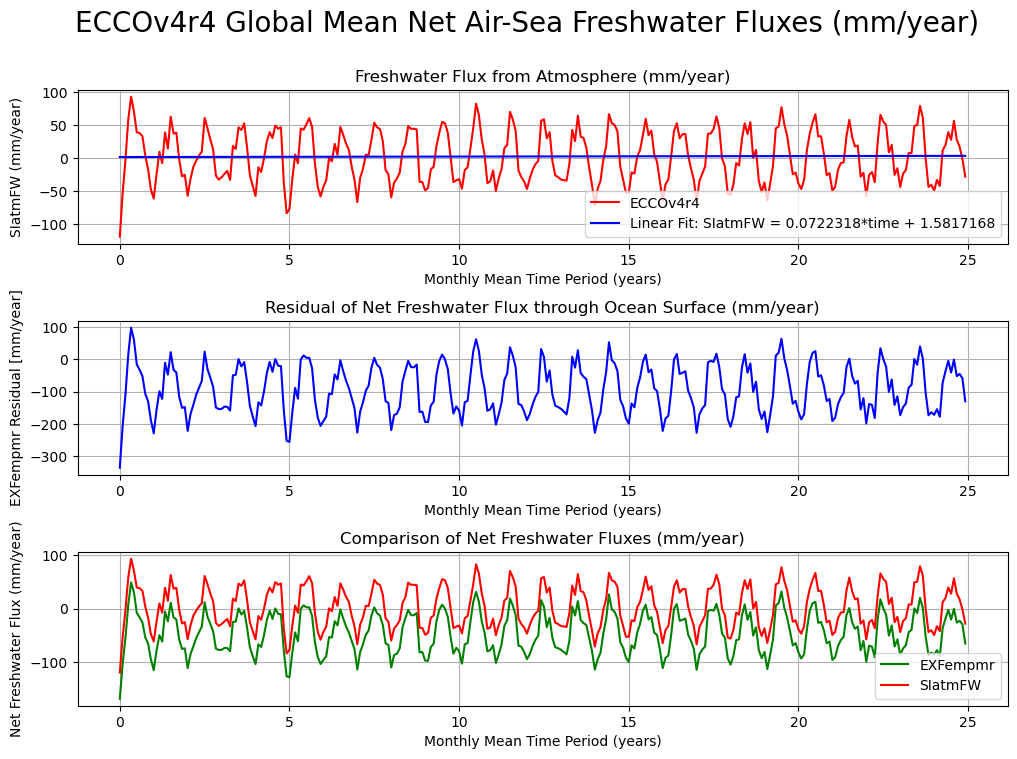

<Figure size 640x480 with 0 Axes>

In [27]:
# Convert xarray.DataArray objects storing freshwater flux property values into numpy arrays
# for linear regression model fitting

SIatmFW_area_weighted = np.array(SIatmFW_area_weighted)
EXFempmr_residual_area_weighted = np.array(EXFempmr_residual_area_weighted)

# Initialize figure geometry with three subplots grids for net freshwater flux visualizations

fig, axs = plt.subplots(3, 1, figsize = (12, 8))

# Time Series of area-weighted mean Net Freshwater Flux due to atmosphere-
# sea-ice transfer 

plt.sca(axs[0])
axs[0].plot(time, SIatmFW_area_weighted,color='r')
            
# Fit Linear Regression Model to SIatmFW Time-Series Data

m, b = np.polyfit(time, SIatmFW_area_weighted, 1) 
m_r = round(m, 7)
b_r = round(b, 7)

# Render Linear Best Fit Line Plot 

axs[0].plot(time, m*time + b, 'b')
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel('SIatmFW (mm/year)');
plt.legend(['ECCOv4r4', 'Linear Fit: SIatmFW = ' + str(m_r) + \
            '*' + 'time + ' + str(b_r)]);
plt.title("Freshwater Flux from Atmosphere (mm/year)")
plt.grid()

# Freshwater Flux Residual through Ocean Surface
# (EXFempmr - (EXFevap - EXFpreci - EXFroff))

plt.sca(axs[1])
axs[1].plot(time, EXFempmr_residual_area_weighted,color='b')
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel('EXFempmr Residual [mm/year]')
plt.title("Residual of Net Freshwater Flux through Ocean Surface (mm/year)")
plt.grid()

# Comparison of Net Freshwater Flux from Atmosphere to Net Freshwater
# Flux through Ocean Surface

plt.sca(axs[2])
axs[2].plot(time, EXFempmr_area_weighted,color='g')
axs[2].plot(time, SIatmFW_area_weighted,color='r')
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel('Net Freshwater Flux (mm/year)')
plt.title("Comparison of Net Freshwater Fluxes (mm/year)")
plt.grid()
plt.legend(['EXFempmr', 'SIatmFW']);

#Render figure title

plt.subplots_adjust(hspace = .5, wspace = 0.5)
plt.suptitle('ECCOv4r4 Global Mean Net Air-Sea Freshwater Fluxes (mm/year)',
                 fontsize=20);
plt.show();

# Save figure to local file system as '.png'

plt.savefig(output_dir + '/global_mean_eccov4r4_air_sea_net_freshwater_fluxes.png')

## Procedure and Analysis of Net Freshwater Flux Time-Series Plots for ECCOv4r4 Model Output

### Procedure Summary

1. The monthly-mean net air-sea freshwater fluxes from the ECCOv4r4 model datasets (spanning a time period of 1992-2017), were read into a single 'xarray.Dataset' object
2. Then, redundant coordinates were dropped from both objects to reduce the workspace's memory footprint.
3. From here, the 'xarray.DataArray' objects corresponding to the individual net air-sea freshwater flux terms were indexed from the 'xarray.Dataset' object and assigned to individual variables
4. Then, the globally-integrated, area-weighted mean (horizontal spatially-averaged, area-weighted mean) freshwater flux values were obtained for each month in the time period using the 'masked area array' and 'xgcm grid object'.
5. Next, the arrays were converted into 'numpy.ndarray' objects to enable rendering of the data using matplotlib plotting routines
6. Then, a figure with time-series line plots of the air-sea freshwater flux at the sea surface was rendered as shown above, and linear regression was used to fit a first degree polynomial equation to the applicable data sets as before.
7. Lastly, the figure was saved to the local filesystem.

### Analysis of Results


FINISH

### Questions and Concerns

1. Why does the global mean net freshwater flux into the ocean (EXFempmr) tend towards a minimum at the beginning of the year when most of the surface ocean (i.e. in the southern hemisphere) is in peak summer season with warmer atmosphere and sea surface temperatures and a maximum during the middle of the year when this same regional domain is in peak winter season with cold temperatures? What is the physical explanation behind why it is not the other way around?
2. Same question for the global mean net freshwater flux from atmosphere to sea-ice
3. What is the reasoning behind why the global mean net freshwater flux from the atmosphere (SIatmFW) is consistently higher than the global mean net freshwater flux into the ocean (EXFempmr) over this time period? Does this exclusively have to do with part of the freshwater input in the sea-ice accounted for in the SIatmFW term evaporating back into the atmosphere instead of being input through the ocean surface and thus not appearing in the EXFempmr term or are there other factors at play here?  

### Comparison of Ocean Basin Mean Net Heat and Freshwater Flux (Minus Runoff) Time-Series Containing CORE.v2 Model Data over 1950-2006 and ECCOv4r4 Model Data over 1992 - 2017

#### Render Time Series Containing Model Data

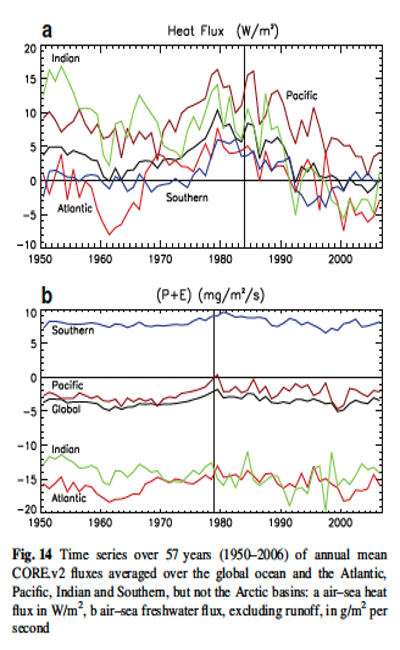

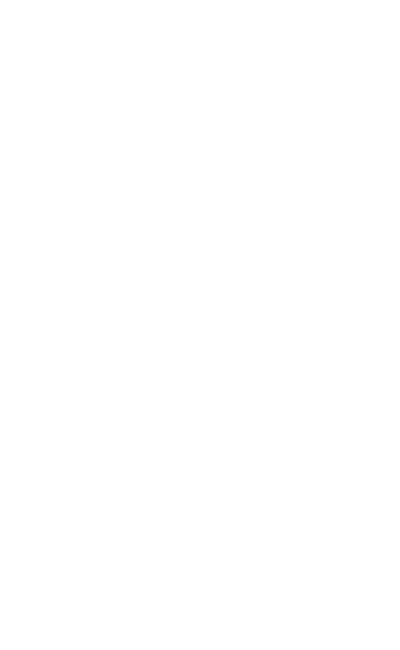

In [28]:
# Render ocean basin mean heat and freshwater flux time-series for CORE.v2 data

plots_dir = base_repo_dir + '/references/Large_Yeager/images/plots/Time_Series_COREv2_air_sea_fluxes.png'
im_1 = PIL.Image.open(plots_dir)
im_1 = im_1.resize((400,650))
im_1.show()

# Render ocean basin mean heat and freshwater flux time-series for ECCOv4r4 data

plots_dir = output_dir + '/basin_mean_eccov4r4_air_sea_fluxes.png'
im_2 = PIL.Image.open(plots_dir)
im_2 = im_2.resize((400,650))
im_2.show()

#### Interpretation of CORE.v2 Ocean Basin Air-Sea Heat Fluxes Time-Series Plots

The figure shown above depicts the ocean basin spatial mean net heat fluxes and net freshwater fluxes (minus runoff) respectively output from the CORE.v2 model for the time period of 1950 - 2006 for four ocean basins. As shown in the top-most subplot, the Indian and Pacific Ocean basins have made the largest contributions to net heat input in the global ocean over this time period with the former steadily declining throughout this time span to between a moderately and slightly negative net heat input over the last couple of decades in the dataset. The contribution to the net heat input from the Southern Ocean basin has been largely minimal and somewhat time-invariant with the largest positive contributions over the late 1970s through early 1990s before leveling off again at the upper end of the time domain. The Atlantic Ocean basin has the largest negative contribution to the net heat input over this time span thus exhibiting a net cooling effect at the ocean surface with by far the largest spatial mean heat flux cooling of any of the ocean basins in the early 1960s and early 2000s. A linear combination of these ocean basin mean heat flux trends produces the global mean trend shown in black which, as expected, has a trend dominated by that of the Pacific Ocean mean heat flux fluctuating slightly from a mean of about 5 W/m2 from the 1950s through the late 1970s before reaching a peak of approximately 10 W/m2 with the Pacific Ocean basin around the late 1970s before linearly dropping off to a negligible net heat flux at the upper-end of this time period. This trend suggests that, although there have been noticeable annual fluctuations in the global mean heat flux over this multi-decadal time period, the most recent contributions to the ocean surface heat flux have been through a net cooling effect in particular over the final three decades of the time period. Contrary to popular belief then, the rate of ocean surface warming has been slowing over the last few decades.

In referencing the bottom subplot, each of the ocean basin mean net freshwater fluxes (minus runoff) have minor annual fluctuations and remain relatively constant with time. Perhaps most notably, the Southern Ocean basin has the smallest mean fluctuations of any ocean basin with the largest positive contribution to freshwater flux (excluding glacial and river runoff). This agrees with the expectation that the net freshwater flux in high latitudes that the Southern Ocean encompasses be dominated by positive freshwater input from glacial and sea-ice melting. The Pacific Ocean basin has the smallest negative (reduction) mean contribution to the global freshwater flux with an average of about -3 W/m2. The basin's trend peaked at a slightly positive contribution in the late 1970s and the largest negative contribution in the late 1990s. Lastly, the Indian and Atlantic Ocean basins have the largest time variability in mean freshwater flux with their maximum values at the lower-end of the time domain, and minimum values towards the upper-end around the late 1990s. The moderate differential in mean value slowly dissolves as time progresses from the 1950s onwards before significant overlap is experienced from the late 1970s through late 1990s. The large mean negative contribution to the global mean freshwater flux from these two ocean basins is reasonable considering that neither of these ocean basins contain a significant amount of ice cover and thus evaporation is expected to dominate freshwater input through precipitation. Lastly, the Pacific Ocean dominates the ocean basins' contribution to the global mean freshwater flux due to the basin accounting for by far the largest percentage of the global ocean surface. The plot reflects a global mean freshwater flux of approximately -3 W/m2 that has been largely time-invariant. Thus, global mean evaporation has slightly dominated global mean precipitation, although with freshwater runoff, the global mean net freshwater flux is slightly positive over this time span. This trend supports the well-accepted measurements of steady global sea-level rise.


More details regarding the researchers' procedures, assumptions, and analysis can be found in the articles whose citations are provided in the '/references/README.md' file.

#### Comparison of ECCOv4r4 and CORE.v2 Ocean Basin Air-Sea Heat Fluxes Time-Series Plots

# FINISH

### QUESTIONS AND CONCERNS

1. Troubleshoot the discrepancies in time series patterns between ocean basin mean net heat and freshwater flux plots for the two models


# Ocean Surface Potential Temperature Time-Series Analysis

In [29]:
# Extract xarray.DataArray object corresponding to sea-surface temperature values

SST_arr = SST_monthly_mean_ds.THETA.isel(k = 0)

### Evaluate Area-Weighted, Horizontally-Averaged SST from ECCOv4r4 Model Output

In [30]:
# Evaluate Globally-Integrated Area-Weighted Mean of sea-surface temperature to obtain
# one resultant globally-integrated, area-weighted mean value for each month in time period

SST_area_weighted = (SST_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

### Render SST Time-Series Plot for ECCOv4r4 Model Output

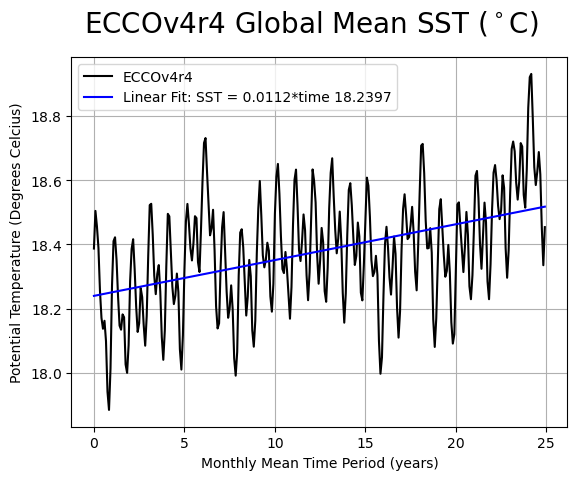

In [31]:
# Convert xarray.DataArray object storing SST values into numpy array for linear regression
# model fitting

SST_area_weighted_np = np.array(SST_area_weighted)

# Render Time Series Plot of Globally-Integrated, Area-Weighted Mean SST

plt.plot(time, SST_area_weighted_np, color='k')
plt.ticklabel_format(axis='y', style='sci', useMathText=True)

# Fit Linear Regression Model to SST Time-Series Data

m, b = np.polyfit(time, SST_area_weighted_np, 1) 
m_r = round(m, 4)
b_r = round(b, 4)

# Render Linear Best Fit Line Plot 
plt.plot(time, m*time + b, 'b')
plt.grid()
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel('Potential Temperature (Degrees Celcius)');
plt.legend(['ECCOv4r4', 'Linear Fit: SST = ' + str(m_r) + \
            '*' + 'time ' + str(b_r)]);

plt.suptitle('ECCOv4r4 Global Mean SST ($^\circ$C)', 
                 fontsize=20);

# Save figure to local file system as '.png'

plt.savefig(output_dir + '/global_mean_eccov4r4_SST.png')

### Procedure and Analysis of SST Time-Series Plot for ECCOv4r4 Model Output

#### Procedure Summary

1. The monthly-mean SST values from the ECCOv4r4 model datasets (spanning a time period of 1992-2017), were read into a single 'xarray.Dataset' object
2. Then, redundant coordinates were dropped from both objects to reduce the workspace's memory footprint.
3. From here, the 'xarray.DataArray' object corresponding to the SST was indexed from the 'xarray.Dataset' object and assigned to an individual variable
4. Next, only values at the sea surface (top-most depth level k = 0) were retained
5. Then, the globally-integrated, area-weighted mean (horizontal spatially-averaged, area-weighted mean) SST values were obtained for each month in the time period using the 'masked area array' and 'xgcm grid object'.
6. Next, the array was converted into 'numpy.ndarray' objects to enable rendering of the data using matplotlib plotting routines
7. Then, a figure with a time-series line plot of the air-sea freshwater flux at the sea surface was rendered as shown above, and linear regression was used to fit a first degree polynomial equation to the applicable data as before.
8. Lastly, the figure was saved to the local filesystem.

#### Analysis of Results

It is evident in this line plot that there is a positive linear trend between potential temperature and time with seasonal variations realized through annual periodic fluctuations shown in the steep inclines and declines throughout the plot. The former remark is realized through a linear regression model that appears to fit the data quite well. The annual periodic fluctuations are similar in shape over time and the annual maximum change in potential temperature over each of the yearly time periods remains relatively constant. These near annual invariabilities suggest to a large degree that while the spatially-averaged sea surface temperature has increased steadily from 1992 to 2017, it has done so while preserving spatially-averaged seasonal fluctuations in temperature within annual time increments.   

# Analysis of Vertical Transport of Heat and Internal Heat Redistribution over Multidecadal Time Periods

The purpose of this section will be to explore the multidecadal shift in the rate of upper-layer temperature warming in the global ocean and on an ocean basin basis and any relationships between cooling-warming compensation in the ocean basins over the time period of 1993-2012. According to Nieves et al (2015), these time periods were chosen based on "the assumption that the [surface temperature hiatus] began in approximately 2003, when there was a small local maximum in the 5-year moving average of global surface temperature". This analysis will be realized through line plots that examine the monthly mean spatially-integrated temperature variation with depth in each of the ocean basins in addition to ocean isotherms that will depict zonal monthly mean temperature trends over the same basins. Efforts will then be made to compare these trends from the ECCO v4r4 datasets to temperature trends presented in a research article entitled "Recent hiatus caused by decadal shift in Indo-Pacific heating" by Nieves et al. (2015). The researchers' results are applicable to the same time periods, and ocean basins, using a number of observational-estimate, observational-in-situ and simulated-assimilated datasets that differ from that of the sources of the author's ECCOv4r4 datasets. These are provided as follows: 
    

Observational-Estimate Temperature Trends: 
    
1) World Ocean Atlas (WOA) 
2) Ishii
2) Scripps Institute of Oceanography (ARGO)

Assimilated-Simulated Temperature Trends (based on reanalyses that assimilate ocean data)

1) Simple Ocean Data Assimilation (SODA)
2) National Centers for Environmental Prediction Global Ocean Data Assimilation System (NCEP GODAS)
3) European Centre for Medium-Range Weather Forecasts ocean reanalysis system(ECMWF ORAS4)

## Analysis of Global Mean Temperature Trends as a Function of Depth

In [32]:
# ECCOv4r4 Model Output

THETA_arr = SST_monthly_mean_ds.THETA

# Index temperature data into three time periods and over depth range (0-1500 m)
# where a depth level of k = 0 corresponds to approximately 5 meters in depth
# and a depth level of k = 34, approximately 1517 meters in depth

THETA_90s = THETA_arr.isel(time = range(12,132), k = range(0,34))
THETA_00s = THETA_arr.isel(time = range(132,252), k = range(0,34))
THETA_00s_minus_90s = THETA_arr.isel(time = range(12,252), k = range(0,34))

# Define numpy array of depth values in 'Z' coordinate system that 
# correspond to 'k' depth levels in 'THETA_arr' arrays

Z = -np.array(ecco_v4r4_grid.Z)
Z = Z[0:34]

# Define numpy array of time values (in integer data format) to 
# incorporate into global mean temperature calculations

time_90s = np.arange(1993, 2003, 1/12)
time_00s = np.arange(2003, 2013, 1/12)

### Evaluate Area-Weighted Horizontally-Averaged Potential Temperature from ECCOv4r4 Model Output

In [33]:
# Evaluate Global Mean Temperature Variations as a function of depth and time for 
# depth range of ~ (0-1500 m) and over time periods of 1993-2002, and 2003-2012

THETA_global_area_weighted_horz_mean_90s = ((THETA_90s * area_masked).sum(\
                         dim = ('i', 'j', 'tile'))) \
                        /(area_masked.sum())

THETA_global_area_weighted_horz_mean_00s = ((THETA_00s * area_masked).sum(\
                         dim = ('i', 'j', 'tile'))) \
                        /(area_masked.sum())


### Define Function for Evaluating Global and Ocean Basin Temperature Trends by Fitting Time-Series Data to Linear Regression Models

In [34]:
def get_lin_reg_temp_trends(THETA_area_weighted_90s, THETA_area_weighted_00s,\
                           domain = 'global'):
    
    """
    Compute potential temperature trends by fitting linear regression models to 
    potential temperature time-series datasets specified in 
    'xarray.DataArray' input arguments given:
    
    - THETA_area_weighted_90s: contains time-series datasets for 90s (xarray.DataArray)
    - THETA_area_weighted_00s: contains time-series datasets for 00s (xarray.DataArray)
    - domain: string to distinguish between global and regional (ocean basin) domains
  
    """
    
    # Define numpy array with monthly mean time values for each decadal time period

    time_90s = np.arange(1993, 2003, 1/12)
    time_00s = np.arange(2003, 2013, 1/12)
    
    # Loop through each depth level of input arrays and evaluate the mean slope of a 
    # linear regression model fit to that depth level's temperature time-series dataset

    if (domain == 'regional'):

        m_90s_trend = np.zeros(20)
        m_00s_trend = np.zeros(20)

    else: 

        m_90s_trend = np.zeros(34)
        m_00s_trend = np.zeros(34)

    for i in range(0, len(THETA_area_weighted_90s.isel(time = 0).values)):

        # Fit Linear Regression Model to time-series temperature data for 'ith' depth-level

        m_90s, b_90s = np.polyfit(time_90s, THETA_area_weighted_90s.isel(k = i).values, \
             1) 
        m_00s, b_00s = np.polyfit(time_00s, THETA_area_weighted_00s.isel(k = i).values, \
            1) 

        # Assign temperature trend values from current depth to resultant array

        m_90s_trend[i] = m_90s
        m_00s_trend[i] = m_00s
    
                                  
    return m_90s_trend, m_00s_trend

### Evaluate Global Temperature Trends for Both Decadal Periods

In [35]:
m_90s_trend_global, m_00s_trend_global = get_lin_reg_temp_trends(THETA_global_area_weighted_horz_mean_90s, \
                                                                THETA_global_area_weighted_horz_mean_00s)

# Difference in global mean temperature trends across the two time periods

m_00s_minus_90s_trend_global = m_00s_trend_global - m_90s_trend_global

### Render Global Mean Temperature as Function of Depth Trend Plots for ECCOv4r4 Model Output

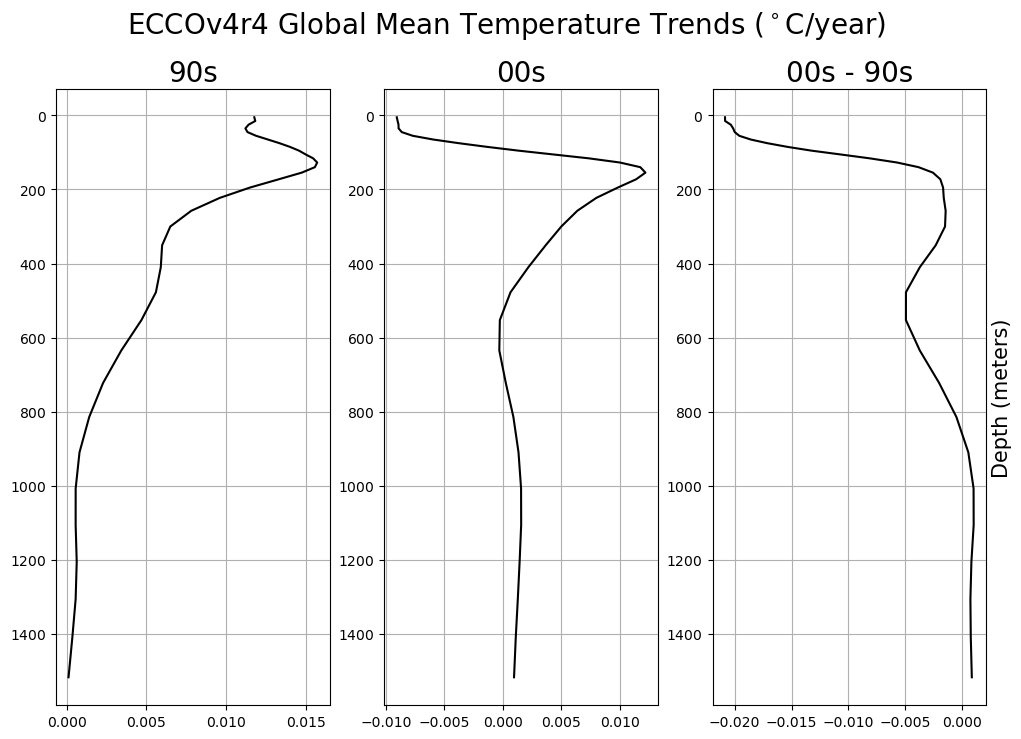

In [36]:
# Initialize figure geometry with three subplot grids for global mean temp trends

fig, axs = plt.subplots(1, 3, figsize = (12,8))
axs = axs.flatten()

# Render Line Plot of Global Mean Temperature Trend for 1993 - 2002 
# (deg Celsius/year)

plt.sca(axs[0]) 
axs[0].plot(m_90s_trend_global, Z, color='k')
plt.gca().invert_yaxis()
plt.ticklabel_format(axis='y', style='sci', useMathText=True)
plt.title('90s',fontsize=20)
plt.grid()

# Render Line Plot of Global Mean Temperature Trend for 2003 - 2012
# (deg Celsius/year)

plt.sca(axs[1]) 
axs[1].plot(m_00s_trend_global, Z, color='k')
plt.gca().invert_yaxis()
plt.ticklabel_format(axis='y', style='sci', useMathText=True)
plt.title('00s',fontsize=20)
plt.grid()

# Render Line Plot of Global Mean Temperature Trend for 1993 - 2012 
# (deg Celsius/year)

plt.sca(axs[2]) 
axs[2].plot(m_00s_minus_90s_trend_global, Z, color='k')
plt.gca().invert_yaxis()
plt.ticklabel_format(axis='y', style='sci', useMathText=True)
plt.title('00s - 90s',fontsize=20)
plt.grid()
plt.ylabel('Depth (meters)', fontsize = 15);
axs[2].yaxis.set_label_position("right")

#Render figure title
plt.suptitle('ECCOv4r4 Global Mean Temperature Trends ($^\circ$C/year)',
                 fontsize=20);

# Save figure to local file system as '.png'

plt.savefig(output_dir + '/global_mean_eccov4r4_temp_trends.png')

### Procedure for and Analysis of Global Mean Temperature Trend Plots for ECCOv4r4 Model Output

### Procedure Summary

1. First, the 'xarray.DataArray' object corresponding to the SST was indexed from its parent 'xarray.Dataset' object and assigned to an individual variable.
2. Next, two 'xarray.DataArray' objects were indexed with SST values corresponding to two time domains of interest (1993-2002 and 2003-2012) and where each array has values that span a spatial depth domain of approximately 0 - 1500 meters.
3. Then, the area-weighted, horizontally-spatially averaged temperature values were evaluated over the global ocean for both of the time periods.
4. From here, the potential temperature trends were computed by fitting linear regression models to the temperature time-series datasets for each decadal time-periods' depth-levels.
5. Then, a figure with the time-series line plots of the temperature trends as a function of depth was rendered for the two timer periods as shown above.
6. Lastly, the figure was saved to the local filesystem.

### Analysis of Results




### Render Global Mean Temperature Trends for each Decadal Period from Nieves et al. Observational and Assimilated Data Sources over 1993-2012

In [40]:
import PIL.Image

plots_dir = base_repo_dir + '/references/Nieves_et_al/images/plots/global_mean_temp_trends_Nieves_et_al.png'
im = PIL.Image.open(plots_dir)

im.show();


### Background of Nieves et al. (2015) Global Mean Temperature Trend Analysis

The figure presented above contains the global mean temperature trends (temperature rates) as a function of depth for three decadal time periods for observational-estimate, observational-in-situ and simulated-assimilated model datasets discussed in the research article by Nieves et al. (2015). As shown in the first subplot, there is a considerable spread in the global mean temperature rate at the ocean surface across all of the datasets for the decadal time period of the 90s with one of the observational-in-situ datasets depicting the smallest temperature rate (slight cooling in mean temperature at the global ocean surface) with the WOA, ISHII, and ARGO observational-estimate model datasets depicting as much as a one magnitude difference in the rate of warming at the global ocean surface. Each of the temperature datasets experience a very similar trend with depth. In particular, it is shown that there is a noticeable cooldown in the upper ocean in the top 100 meters. Below about 300 meters the distribution of the ISHII data begins to deviate from that of the observational-in-situ data and the other observational-estimate models with a somewhat steady decline in the rate of warming to about 550 meters whereas the other trends depict a relatively steady increase in the rate of warming to about 400 meters depth before steadily declining with the ISHII model to about 550 meters. In looking at the second subplot, it is shown that the observational-estimate model trends approximate the observational-in-situ trends very well. In particular, they exhibit a steady reduction in the rate of warming from the ocean surface to a minimum rate of cooling of roughly -0.01 degrees Celsius per year in the top 100 meters before steadily increasing to a maximum rate of warming of about 0.01 degrees Celcius per year at roughly 250 meters depth, and then ultimately dropping off gradually to a very small rate of warming that fluctuates between approximately 0 and 0.003 degrees Celcius per year below 500 meters depth. According to Nieves et al. (2015) then, the differences in the warming rates between the two decades shown in the third subplot reflect "substantial temperature slowdown in the past decade near the surface for all observational-estimate trends. 

Looking now at subplots 4-6 that reflect the mean temperature trends with depth from simulated assimilated models including NCEP, SODA, and ECMWF relative to observational-in-situ trends, it is evident that there is a much larger spread in the trends across all decadal periods in comparison to that of the observational-estimate model trends. Despite the differential in spread between the observational-estimate and simulated-assimilated model trends, the plots exhibit very similar shapes for the respective decadal time periods. In particular, the trends begin with a small warming rate at the ocean surface before steadily dropping off to a negligible warming rate/slight cooling rate at about 100 meters depth before zigzagging with depth and ultimately dropping off somewhat steadily from about 200 - 400 meters depth to around 500 meters depth. From here, there is a much larger spread in the temperature rate with depth in the simulated trends with NCEP dropping off to as much as a half-magnitude factor of cooling rate greater any of the observational-in-situ or observational-estimate trend counterparts. In referencing the fifth subplot, much of the same similarities can be shown between the observational-estimate and simulated trends, again, with the main difference being a larger spread in the temperature rate for the latter. This is most realized in the NCEP trend which experiences the largest spread from the mean of the observational-estimate trends of any of the simulated trends exhibiting a behavior that is almost opposite that of its 1990s counterpart from about 200 meters and below. With exception to this model, then, the simulated temperature rate trends in the last subplot suggest a noticeable temperature slowdown in the past decade near the ocean surface similar to the observational-estimate temperature trends.

Table 3 contains global-mean air-sea heat flux property values over the time period of 1984-2006 over which there is partial overlap with the ECCOv4r4 time period of 1992-2017. According to Large and Yeager (2009), the procedure in the research study "utilizes an alternative approach to provide global estimates of all the air-sea fluxes that capture as much interannual variability as possible. In the process, a complete suite of flux parameters has been assembled, which can provide interannually varying forcing for ocean and sea-ice models, including CORE". According to Griffies et al. (2008), The "CORE" model framework is regarded as a coupled ocean-ice Coordinated Ocean Research Experiments model where air-sea fluxes are computed from prognostic SST. Incorporated into this framework is sub-daily wind resolution of the inertial period and storm events. 

Additionally, the fluxes are independent of ocean transport estimates as well as self-consistent. Large and Yeager (2009) summarize the procedure through which air-sea heat fluxes are obtained using CORE as, the "fluxes are computed from forcing data sets assembled by Large and Yeager (2004)" where "the key approach is to reduce known biases, by comparing to more accurate and reliable observations that are either too regional, or too short to be suitable themselves". The second version of the forcing data and the accompanying model from which CORE fluxes were computed,(the subject of the study by Large and Yeager (2009)), is denoted as "CORE.v2". All datasets rendered in tables and plots by Large and Yeager (2009) in this notebook will be from the CORE.v2 coupled ocean-ice model. 


More details regarding the researchers' procedures, assumptions, and analysis can be found in the articles whose citations are provided in the '/references/README.md' file.

### Comparison of ECCOv4r4 Model and Nieves et al. Observational-Estimate and Simulated-Assimilated Model Global Mean Temperature Trends as a Function of Depth

In comparing the global mean temperature trends with respect to depth of the ECCOv4r4 model to the models presented in Nieves et al., it is shown that there is a similar cooling trend in the upper ocean for both the ECCOv4r4 and the WOA models during the time period of 1993-2002. In particular, the temperature rates start out as slight warming rates at the ocean surface with the ECCOv4r4 trend experiencing a global mean warming rate of approximately 11e-3 degrees celcius per year compared to roughly 13e-3 degrees celsius per year for the WOA model. The two trends experience similar behavior from the ocean surface to approximately 40 meters depth through a linear reduction in the cooling rate, before exhibiting a deviation in behavior between this depth and approximately 150 meters. In particular, the ECCOv4r4 trend suggests a linear increase in the warming rate with depth to a maximum of 16e-3 degrees Celcius per year at about 150 meters whereas the WOA trend suggests a depth-mean reduction in the cooling rate between these two depths with minor fluctuations in this cooling rate trend realized through the plots' zig-zag pattern. From about 150 meters depth and below, the two trends are very similar exhibiting a depth-mean linear reduction in the warming rate before approaching a negligible mean warming rate at lower depths. It is shown that this reduction in warming rate is more gradual for the ECCOv4r4 trend which approaches 1e-3 and roughly 0 degrees celsius per year at 1000 meters and 1500 meters depth respectively, whereas the reduction in the warming rate for the WOA trend is much more progressive with depth approaching 1e-3 and 0 degrees/year warming rates at about 450 meters and 500 meters depth respectively. To this point, the mean warming rate of the ECCOv4r4 trend at depths of 450 and 500 meters is about a half of magnitude larger, namely, approximately 5e-3 degrees Celcius per year. 

Shifting gears to comparing trends between the ECCOv4r4 model and that of the observational-estimate models for the period of 2003-2012, it is first shown that there is noticeable discrepancy between the mean temperature trends at the ocean surface for the ECCOv4r4 and the observational-estimate models. In particular, there is nearly a one magnitude difference in the temperature rate between the two figures with the ECCOv4r4 trend suggesting a global mean temperature rate of approximately -8e-3 degrees Celsius per year compared to mean of approximately 2.5e-3 for the observational-estimate models. This is significant not only because of the difference in the order of magnitude but also because the former suggests a global mean cooling at the ocean surface compared to a global mean warming for the latter. From the ocean surface down to approximately 180 meters depth there remains a difference in the trends with the ECCOv4r4 model suggesting a slight linear increase in the warming rate to a maximum value of roughly 12e-3 degrees Celcius per year at 180 meters. In comparison, the observational-estimate trends suggest a linear decrease in the warming rate from the ocean surface to about 80 meters depth to a maximum cooling rate of between 10e-3 and 13e-3 degrees Celsius per year before exhibiting a linear increase in the warming rate from this depth to about 180 meters similar to the ECCOv4r4 trend. An important distinction here is that the mean maximum warming rate that the observational-estimate trends reach over this depth domain is considerably less than that of the ECCOv4r4 trend, namely, about 6e-3 degrees Celsius per year with the observational-in-situ data being the closest at about 12e-3. Below this depth, the trends are almost identical suggesting a gradual reduction in the warming rate to a minimum of about 1e-3 degrees Celcius per year at roughly 600 meters depth with minor fluctuations of no more than 10% of an order of magnitude from this minimum warming rate from 600 meters to 1500 meters depth. It is also worth noting that the ECCOv4r4 trend most closely resembles that of the ARGO model below 600 meters with the distinctive similarities in curvature. 

Lastly, in comparing the changes in global mean temperature trends from the 90s - 00s between the ECCOv4r4 trend and the observational-estimate trends the figures' third plots suggest that the mean temperature rates exhibit very similar behavior with depth to their 00s counterparts. Putting aside the differences in the curvature of the trends, it is shown that all models suggest a mean cooling rate over the global upper ocean from depths of 150 meters upward to the surface with a maximum cooling rate of about 18e-3 degrees Celcius per year for the observational-esimate trends and a similar value of about 21e-3 degrees Celcius per year for the ECCOv4r4 trend. Between roughly 150 and 500 meters depth the observational-estimate trends fluctuate between mean cooling rates as high as 18e-3 degrees Celcius per year and mean warming rates as high as 10e-3 degrees Celcius per year with the ECCOv4r4 trend suggesting gradual changes with depth in the mean cooling rate that fluctuate between 2e-3 and 5e-3 degrees Celcius per year over this depth domain. Below 500 meters, the mean cooling transitions into a mean warming and fluctuates minimally with depth between about -4e-3 and 5e-3 degrees Celcius per year. In comparison, the ECCOv4r4 trend suggests a moderate linear increase in the warming rate from about -5e-3 degrees Celcius per year at 500 meters to roughly 1e-3 degrees Celcius per year at about 1000 meters. Overall, the temperature trend in the ECCOv4r4 model agrees fairly well with that of the observational-estimate trends in the upper ocean above 150 meters with all models suggesting a substantial reduction in temperature albeit noticeable differences in curvature with depth. However, below 500 meters the observational-estimate trends agree with the ECCOv4r4 trend very well in both the shape and magnitudes of the plot trends with all trends suggesting a gradual increase in the warming rate with depth and reaching an approximately constant trend of between 1e-5 and 5e-3 degrees Celcius per year.

# FINISH

### QUESTIONS AND CONCERNS

1. Confirm behavior of plots and that explanations of behavior are correct


### REFERENCE ANSWERS TO QUESTIONS/CONCERNS PROVIDED ABOVE

## Analysis of Ocean Basin Mean Temperature Trends as a Function of Depth 

In [41]:
# ECCOv4r4 Model Output

# Merge the xarray grid dataset object with xarray SST monthly mean dataset object
# for more efficient operations that link state estimate properties to grid locations

ecco_ds = xr.merge((ecco_v4r4_grid, SST_monthly_mean_ds))

# Define directory path to 'basins.meta' and 'basins.data' files for basin partitioning
data_dir = '/scratch2/jcam98/CRIOS/ECCO_analysis_work/datasets/v4r4/original_output/grid_params'


### Southern Ocean Basin Interpretation

Define Southern Ocean Basin as encompassing latitudes south of -30 N latitude and between -180 and 180 E longitude. This approximation to the Southern Ocean Basin corresponds to a domain that includes areas of the ECCOv4r4's southern-most broad Pacific, Atlantic, and Indian basins and is the most widely-accepted Southern Ocean basin.

### Wrangle SST Data Applicable to Appropriate Ocean Basins, Time Domains, and Depth Level Domains

In [42]:
# Define numpy array of depth values in 'Z' coordinate system that 
# correspond to 'k' depth levels 
Z = -np.array(ecco_v4r4_grid.Z)
Z = Z[0:20]

# Apply applicable ocean basin masks to potential temperature data

THETA_pac_maskC = ecco_ds.THETA * pac_maskC
THETA_atl_maskC = ecco_ds.THETA * atl_maskC
THETA_ind_maskC = ecco_ds.THETA * ind_maskC
THETA_sou_maskC = ecco_ds.THETA # Initialize variable for storing southern ocean mask

# Index potential temperature values for appropriate depth levels and time domains

THETA_pac_maskC_90s = THETA_pac_maskC.isel(time = range(12,132), k = range(0,20))
THETA_atl_maskC_90s = THETA_atl_maskC.isel(time = range(12,132), k = range(0,20))
THETA_ind_maskC_90s = THETA_ind_maskC.isel(time = range(12,132), k = range(0,20))
THETA_sou_maskC_90s = THETA_sou_maskC.isel(time = range(12,132), k = range(0,20))
THETA_pac_maskC_00s = THETA_pac_maskC.isel(time = range(132,252), k = range(0,20))
THETA_atl_maskC_00s = THETA_atl_maskC.isel(time = range(132,252), k = range(0,20))
THETA_ind_maskC_00s = THETA_ind_maskC.isel(time = range(132,252), k = range(0,20))
THETA_sou_maskC_00s = THETA_sou_maskC.isel(time = range(132,252), k = range(0,20))

# Index Southern Ocean basin between 30S and 90 S latitude

lat_bounds = np.logical_and(THETA_sou_maskC_90s.YC >= -90, THETA_sou_maskC_90s.YC <= -30)
lon_bounds = np.logical_and(THETA_sou_maskC_90s.XC >= -180, THETA_sou_maskC_90s.XC <= 180)
THETA_sou_maskC_90s = THETA_sou_maskC_90s.where(np.logical_and(lat_bounds, lon_bounds))
THETA_sou_maskC_00s = THETA_sou_maskC_00s.where(np.logical_and(lat_bounds, lon_bounds))

# Index Pacific, Atlantic, and Indian Ocean basins above 30S latitude

lat_bounds = np.logical_and(THETA_pac_maskC_90s.YC >= -30, THETA_pac_maskC_90s.YC <= 90)
lon_bounds = np.logical_and(THETA_pac_maskC_90s.XC >= -180, THETA_pac_maskC_90s.XC <= 180)
THETA_pac_maskC_90s = THETA_pac_maskC_90s.where(np.logical_and(lat_bounds, lon_bounds))
THETA_pac_maskC_00s = THETA_pac_maskC_00s.where(np.logical_and(lat_bounds, lon_bounds))
lat_bounds = np.logical_and(THETA_atl_maskC_90s.YC >= -30, THETA_atl_maskC_90s.YC <= 90)
lon_bounds = np.logical_and(THETA_atl_maskC_90s.XC >= -180, THETA_atl_maskC_90s.XC <= 180)
THETA_atl_maskC_90s = THETA_atl_maskC_90s.where(np.logical_and(lat_bounds, lon_bounds))
THETA_atl_maskC_00s = THETA_atl_maskC_00s.where(np.logical_and(lat_bounds, lon_bounds))
lat_bounds = np.logical_and(THETA_ind_maskC_90s.YC >= -30, THETA_ind_maskC_90s.YC <= 90)
lon_bounds = np.logical_and(THETA_ind_maskC_00s.XC >= -180, THETA_ind_maskC_00s.XC <= 180)
THETA_ind_maskC_90s = THETA_ind_maskC_90s.where(np.logical_and(lat_bounds, lon_bounds))
THETA_ind_maskC_00s = THETA_ind_maskC_00s.where(np.logical_and(lat_bounds, lon_bounds))

In [97]:
THETA_pac_maskC_90s

<xarray.DataArray (time: 120, k: 20, tile: 13, j: 90, i: 90)>
dask.array<where, shape=(120, 20, 13, 90, 90), dtype=float64, chunksize=(1, 20, 13, 90, 90), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (tile, j, i) float32 -111.6 -111.3 -110.9 ... -99.42 -105.6 -111.9
    YC       (tile, j, i) float32 -88.24 -88.38 -88.52 ... -88.03 -88.08 -88.1
    ...       ...
    rA       (tile, j, i) float32 3.623e+08 3.633e+08 ... 3.685e+08 3.611e+08
    PHrefC   (k) float32 49.05 147.1 245.2 ... 2.185e+03 2.526e+03 2.942e+03
    drF      (k) float32 10.0 10.0 10.0 10.0 10.0 ... 24.85 31.1 38.42 46.5
    hFacC    (k, tile, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    maskC    (k, tile, j, i) bool False False False False ... False False False
  * time     (time) datetime64[ns] 1993-01-16T12:00:00 ... 2002-12-16T12:00:00

### Evaluate Area-Weighted Horizontally-Averaged Potential Temperature as a Function of Time for each Depth from ECCOv4r4 Model Output

In [43]:
# Time Period of 1993 - 2002

THETA_pac_area_weighted_horz_mean_90s = ((THETA_pac_maskC_90s * area_masked_pac).sum(\
                          dim = ('i', 'j', 'tile'))) \
                        / (area_masked_pac.sum())
THETA_atl_area_weighted_horz_mean_90s = ((THETA_atl_maskC_90s * area_masked_atl).sum(\
                          dim = ('i', 'j', 'tile'))) \
                        / (area_masked_atl.sum())
THETA_ind_area_weighted_horz_mean_90s = ((THETA_ind_maskC_90s * area_masked_ind).sum(\
                          dim = ('i', 'j', 'tile'))) \
                        / (area_masked_ind.sum())
THETA_sou_area_weighted_horz_mean_90s = ((THETA_sou_maskC_90s * area_masked_sou).sum(\
                          dim = ('i', 'j', 'tile'))) \
                        / (area_masked_sou.sum())

# Time Period of 2003 - 2012
                                        
THETA_pac_area_weighted_horz_mean_00s = ((THETA_pac_maskC_00s * area_masked_pac).sum(\
                          dim = ('i', 'j', 'tile'))) \
                        / (area_masked_pac.sum())
THETA_atl_area_weighted_horz_mean_00s = ((THETA_atl_maskC_00s * area_masked_atl).sum(\
                          dim = ('i', 'j', 'tile'))) \
                        / (area_masked_atl.sum())
THETA_ind_area_weighted_horz_mean_00s = ((THETA_ind_maskC_00s * area_masked_ind).sum(\
                          dim = ('i', 'j', 'tile'))) \
                        / (area_masked_ind.sum())
THETA_sou_area_weighted_horz_mean_00s = ((THETA_sou_maskC_00s * area_masked_sou).sum(\
                          dim = ('i', 'j', 'tile'))) \
                        / (area_masked_sou.sum())   

In [59]:
len(THETA_pac_area_weighted_horz_mean_90s.values)

120

### Evaluate Temperature Trend Values for each Ocean Basin and Decadal Time Period

In [44]:
# Call function to return arrays of temperature trends for each ocean basin and time period

m_90s_trend_pac, m_00s_trend_pac = get_lin_reg_temp_trends(THETA_pac_area_weighted_horz_mean_90s, \
                                                          THETA_pac_area_weighted_horz_mean_00s, \
                                                          domain = 'regional')
m_90s_trend_atl, m_00s_trend_atl = get_lin_reg_temp_trends(THETA_atl_area_weighted_horz_mean_90s, \
                                                          THETA_atl_area_weighted_horz_mean_00s,  \
                                                          domain = 'regional')
m_90s_trend_ind, m_00s_trend_ind = get_lin_reg_temp_trends(THETA_ind_area_weighted_horz_mean_90s, \
                                                          THETA_ind_area_weighted_horz_mean_00s,  \
                                                          domain = 'regional')
m_90s_trend_sou, m_00s_trend_sou = get_lin_reg_temp_trends(THETA_sou_area_weighted_horz_mean_90s, \
                                                          THETA_sou_area_weighted_horz_mean_00s,  \
                                                          domain = 'regional')

### Render Line Plots of Ocean Basin Mean Temperature Trends for 1993-2002

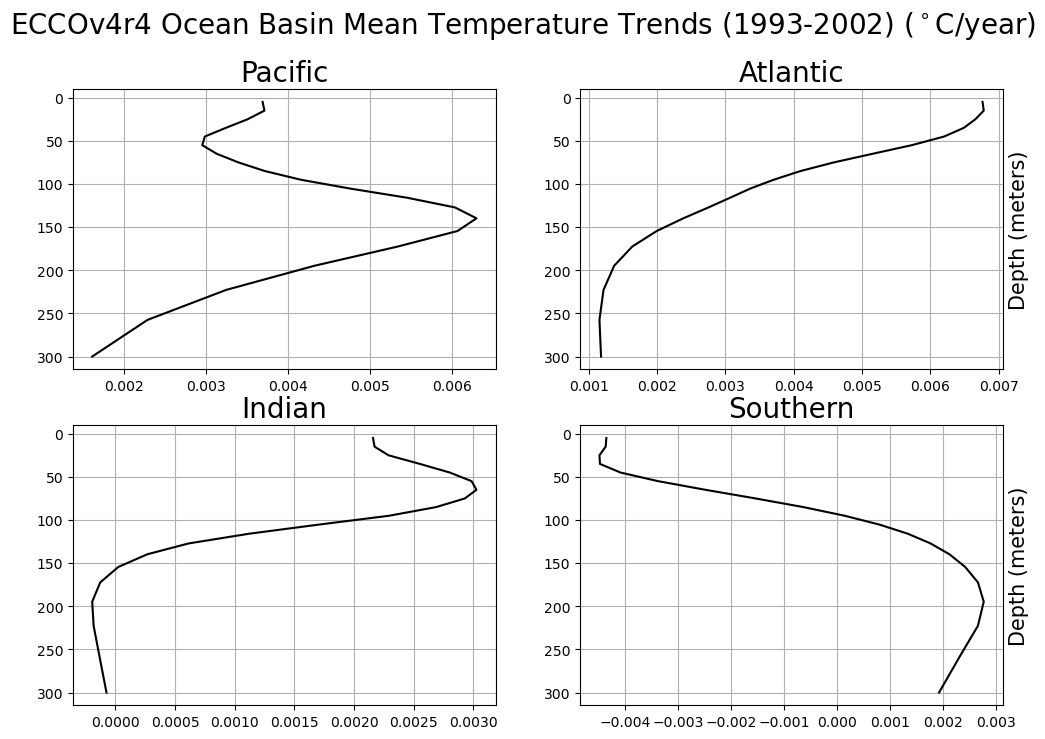

In [45]:
########## Initialize figure geometry with four subplot grids for regional mean temp trends for 1993-2002 #########

fig, axs = plt.subplots(2, 2, figsize = (12,8))
axs = axs.flatten()

# Render Line Plot of Pacific Ocean Basin Regional Mean Temperature Trend for 1993 - 2002 
# (deg Celsius/year)

plt.sca(axs[0]) 
axs[0].plot(m_90s_trend_pac, Z, color='k')
plt.gca().invert_yaxis()
plt.title('Pacific',fontsize=20)
plt.grid()

# Render Line Plot of Atlantic Ocean Basin Regional Mean Temperature Trend for 1993-2002
# (deg Celsius/year)

plt.sca(axs[1]) 
axs[1].plot(m_90s_trend_atl, Z, color='k')
plt.gca().invert_yaxis()
plt.title('Atlantic',fontsize=20)
plt.ylabel('Depth (meters)', fontsize = 15);
axs[1].yaxis.set_label_position("right")
plt.grid()

# Render Line Plot of Indian Ocean Basin Regional Mean Temperature Trend for 1993 - 2002 
# (deg Celsius/year)

plt.sca(axs[2]) 
axs[2].plot(m_90s_trend_ind, Z, color='k')
plt.gca().invert_yaxis()
plt.title('Indian',fontsize=20)
plt.grid()

# Render Line Plot of Southern Ocean Basin Regional Mean Temperature Trend for 1993 - 2002
# (deg Celsius/year)

plt.sca(axs[3]) 
axs[3].plot(m_90s_trend_sou, Z, color='k')
plt.gca().invert_yaxis()
plt.title('Southern',fontsize=20)
plt.grid()
plt.ylabel('Depth (meters)', fontsize = 15);
axs[3].yaxis.set_label_position("right")

#Render figure title
plt.suptitle('ECCOv4r4 Ocean Basin Mean Temperature Trends (1993-2002) ($^\circ$C/year)',
                 fontsize=20);

# Save figure to local file system as '.png'

plt.savefig(output_dir + '/basin_mean_eccov4r4_temp_trends_1993_2002.png')

### Render Line Plots of Ocean Basin Mean Temperature Trends for 2003-2012

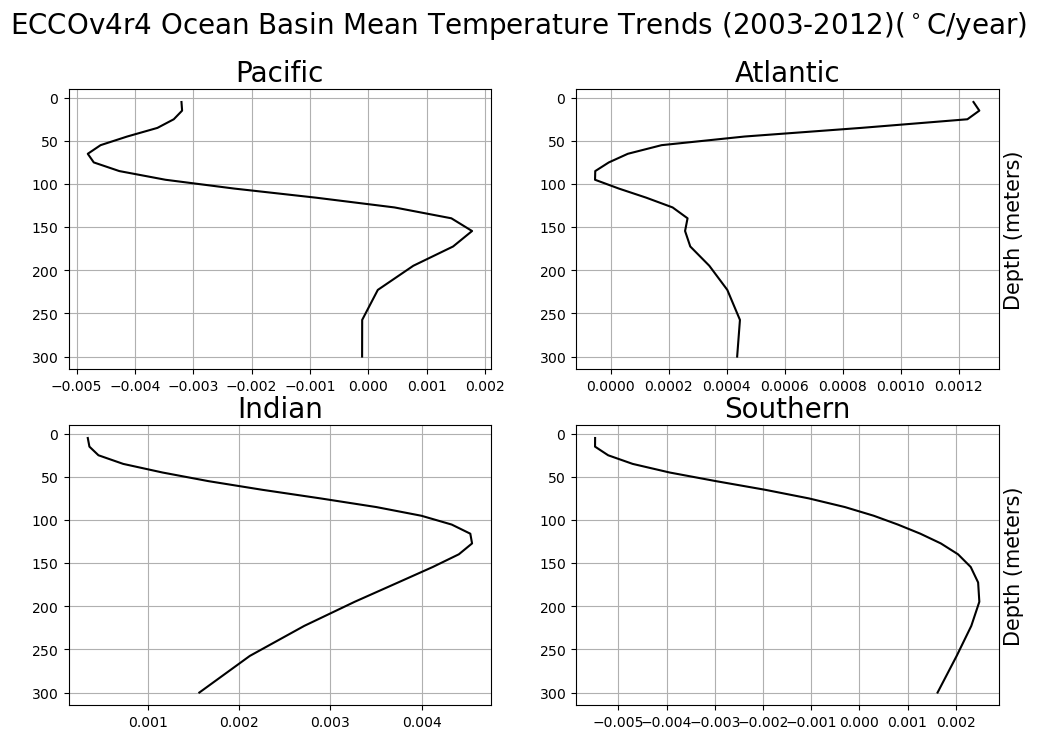

In [46]:
########## Initialize figure geometry with four subplot grids for regional mean temp trends for 2003-2012 #########

fig, axs = plt.subplots(2, 2, figsize = (12,8))
axs = axs.flatten()

# Render Line Plot of Pacific Ocean Basin Regional Mean Temperature Trend for 2003-2012 
# (deg Celsius/year)

plt.sca(axs[0]) 
axs[0].plot(m_00s_trend_pac, Z, color='k')
plt.gca().invert_yaxis()
plt.ticklabel_format(axis='y', style='sci', useMathText=True)
plt.title('Pacific',fontsize=20)
plt.grid()

# Render Line Plot of Atlantic Ocean Basin Regional Mean Temperature Trend for 2003-2012
# (deg Celsius/year)

plt.sca(axs[1]) 
axs[1].plot(m_00s_trend_atl, Z, color='k')
plt.gca().invert_yaxis()
plt.ticklabel_format(axis='y', style='sci', useMathText=True)
plt.title('Atlantic',fontsize=20)
plt.ylabel('Depth (meters)', fontsize = 15);
axs[1].yaxis.set_label_position("right")
plt.grid()

# Render Line Plot of Indian Ocean Basin Regional Mean Temperature Trend for 2003 - 2012
# (deg Celsius/year)

plt.sca(axs[2]) 
axs[2].plot(m_00s_trend_ind, Z, color='k')
plt.gca().invert_yaxis()
plt.ticklabel_format(axis='y', style='sci', useMathText=True)
plt.title('Indian',fontsize=20)
plt.grid()

# Render Line Plot of Southern Ocean Basin Regional Mean Temperature Trend for 2003-2012
# (deg Celsius/year)

plt.sca(axs[3]) 
axs[3].plot(m_00s_trend_sou, Z, color='k')
plt.gca().invert_yaxis()
plt.ticklabel_format(axis='y', style='sci', useMathText=True)
plt.title('Southern',fontsize=20)
plt.grid()
plt.ylabel('Depth (meters)', fontsize = 15);
axs[3].yaxis.set_label_position("right")

#Render figure title
plt.suptitle('ECCOv4r4 Ocean Basin Mean Temperature Trends (2003-2012)($^\circ$C/year)',
                 fontsize=20);

# Save figure to local file system as '.png'

plt.savefig(output_dir + '/basin_mean_eccov4r4_temp_trends_2003_2012.png')


### Procedure and Analysis of Ocean Basin Mean Temperature Trend Plots for ECCOv4r4 Model Output

### Procedure Summary


1. First, the dataset object containing the ECCOv4r4 model grid geometry was merged with the dataset containing the potential temperature values.
2. From here, pre-defined ocean basin masks were applied to the potential temperature dataset.
3. Next, an array was used to define depth values (z) over the range of 0 - 300 meters by associating them with approximate depth levels (k).
4. Next, two 'xarray.DataArray' objects were indexed with temperature values corresponding to two time domains of interest (1993-2002 and 2003-2012) and where each array has values that span a spatial depth domain of approximately 0 - 1500 meters.
5. Then, the area-weighted, horizontally-spatially averaged temperature values were evaluated over the ocean basins for both of the time periods.
6. From here, the potential temperature trends were computed by fitting linear regression models to the temperature time-series datasets for each ocean basin and decadal time-periods' depth-levels.
7. Then, a figure with the time-series line plots of the temperature trends as a function of depth was rendered for each ocean basin and the two time periods as shown above.
8. Lastly, the figures were saved to the local filesystem.


### Analysis of Results

# FINISH

### QUESTIONS AND CONCERNS

1. What is the justification for the discrepancy between the regional patterns that differ noticeably in value over depth although the order of magntitude of the values is expected?


### Perform Zonal Mean Temperature Trend Calculations over time periods (1993 - 2002) and (2003 - 2012)

In [39]:
# Time Period of 1993 - 2002


THETA_pac_zonal_mean_90s = (THETA_pac_maskC_90s).mean('i').mean('tile').mean('time')/time_90s.sum()
THETA_pac_zonal_mean_90s_np = np.array(THETA_pac_zonal_mean_90s)


# THETA_pac_basin_weighted_mean_90s = ((THETA_pac_maskC_90s * area_masked_pac).sum(\
#                           dim = ('i', 'j', 'tile')) \
#                         /(area_masked_pac.sum() * time_90s.sum())).mean('time')

# THETA_atl_basin_weighted_mean_90s = ((THETA_atl_maskC_90s * area_masked_atl).sum(\
#                           dim = ('i', 'j', 'tile')) \
#                         /(area_masked_atl.sum() * time_90s.sum())).mean('time')
# THETA_ind_basin_weighted_mean_90s = ((THETA_ind_maskC_90s * area_masked_ind).sum(\
#                           dim = ('i', 'j', 'tile')) \
#                         /(area_masked_ind.sum() * time_90s.sum())).mean('time')
# THETA_sou_basin_weighted_mean_90s = ((THETA_sou_maskC_90s * area_masked_sou).sum(\
#                           dim = ('i', 'j', 'tile')) \
#                         /(area_masked_sou.sum() * time_90s.sum())).mean('time')

# # Time Period of 2003 - 2012

# THETA_pac_basin_weighted_mean_00s = ((THETA_pac_maskC_00s * area_masked_pac).sum(\
#                           dim = ('i', 'j', 'tile')) \
#                         /(area_masked_pac.sum() * time_00s.sum())).mean('time')

# THETA_atl_basin_weighted_mean_00s = ((THETA_atl_maskC_00s * area_masked_atl).sum(\
#                           dim = ('i', 'j', 'tile')) \
#                         /(area_masked_atl.sum() * time_00s.sum())).mean('time')

# THETA_ind_basin_weighted_mean_00s = ((THETA_ind_maskC_00s * area_masked_ind).sum(\
#                           dim = ('i', 'j', 'tile')) \
#                         /(area_masked_ind.sum() * time_00s.sum())).mean('time')

# THETA_sou_basin_weighted_mean_00s = ((THETA_sou_maskC_00s * area_masked_sou).sum(\
#                           dim = ('i', 'j', 'tile')) \
#                         /(area_masked_sou.sum() * time_00s.sum())).mean('time')

In [40]:
THETA_pac_zonal_mean_90s.values

array([[1.68353446e-05, 1.68951812e-05, 1.75733654e-05, ...,
        1.13601343e-05, 1.13179339e-05, 1.13350485e-05],
       [1.68069602e-05, 1.68620991e-05, 1.75381845e-05, ...,
        1.13439856e-05, 1.13016811e-05, 1.13187340e-05],
       [1.63858360e-05, 1.64256898e-05, 1.71778854e-05, ...,
        1.12583280e-05, 1.12169495e-05, 1.11334349e-05],
       ...,
       [9.52086237e-06, 9.51850249e-06, 9.99300846e-06, ...,
        6.44932624e-06, 6.45252936e-06, 6.43468481e-06],
       [8.79900471e-06, 8.78992802e-06, 9.22124348e-06, ...,
        5.98324820e-06, 6.00928108e-06, 5.99217358e-06],
       [8.06115993e-06, 8.04376312e-06, 8.42495356e-06, ...,
        5.51383094e-06, 5.53955455e-06, 5.52328580e-06]])

## CONSIDER RENDERING CONTOUR PLOTS WITH ISOTHERM CONTOUR LINES FOR OCEAN BASINS HERE

In [41]:

THETA_pac_maskC_XC_90s_np = np.array(THETA_pac_maskC_90s.XC.values)
lats = THETA_pac_maskC_XC_90s_np

# Rescale arrays containing latitudes and potential temperature rates to 
# size of smallest array (depth array) for dimensional compatibility 
# in contour plot rendering




# Fit Regression Model to (potential temperature rate, latitude, depth) dataset
# to attempt to develop association between variables that can be rendered on 
# contour plot

a, b, c = np.polyfit(lats, Z, THETA_pac_maskC_XC_90s_np) 




#plt.contour([THETA_pac_maskC_XC_90s_np, Z], THETA_pac_zonal_mean_90s)
#plt.contourf([THETA_pac_maskC_XC_90s_np, Z], THETA_pac_zonal_mean_90s_np)


# THETA_depth_integrated_90s = THETA_90s.mean('time').mean('k') 
# THETA_depth_integrated_00s = THETA_00s.mean('time').mean('k') 
# THETA_depth_integrated_00s_90s = THETA_00s_90s.mean('time').mean('k') 
                            
####### Render global temperature trends averaged over depth and time

# Initialize figure geometry with three subplot grids for global mean temp trends

# fig, axs = plt.subplots(1, 3, figsize = (14,8))
# axs = axs.flatten()

# # 'cartopy.feature.BORDERS' for country boundaries
# # 'cartopy.feature.COASTLINE' for coastline including major islands
# # 'cartopy.feature.LAKES' for natural and artificial lakes
# # 'cartopy.feature.LAND' for land polygons, including major islands
# # 'cartopy.feature.OCEAN' forr ocean polygons
# # 'cartopy.feature.RIVERS' for single-line drainages, including lake centerlines
# # Let's add geographic borders just to demonstrate how extra features can be added to 
# # a Cartopy map

# # ax.coastlines()
# # ax.add_feature(cfeature.LAND); ax.add_feature(cfeature.BORDERS)
# # plt.colorbar()

TypeError: only size-1 arrays can be converted to Python scalars

### Procedure and Analysis of Ocean Basin Mean Temperature Trend Plots for ECCOv4r4 Model Output

### Procedure Summary


1. First, the dataset object containing the ECCOv4r4 model grid geometry was merged with the dataset containing the potential temperature values.
2. From here, pre-defined ocean basin masks were applied to the potential temperature dataset.
3. Next, an array was used to define depth values (z) over the range of 0 - 300 meters by associating them with approximate depth levels (k).
4. From here, temperature values over the applicable temporal and depth domains were indexed with two arrays defining values over 1993-2002 and 2003 - 2012.
5. Next, the area-weighted horizontally-spatially-averaged mean temperature values were evaluated for each ocean basin and converted into numpy arrays.
6. The ocean basins plots were then rendered on four subplots on two separate figures.
7. Lastly, the figures were saved to the local filesystem.


### Analysis of Results

FINISH USING FEEDBACK FROM QUESTION(S) BELOW

### Questions/Concerns

1. Get clarification on the interpretation of the WOA zonal mean temperature trend plots in Nieves et al. article. My impression is that each contour plot contains longitudinally-and depth - averaged temperature trend values as a function of latitude whose values are proportional to a color hue coupled with actual potential temperature values realized through labelled isotherm (contour) lines

### Render WOA Observational-Estimate Ocean Basin Mean Temperature Trends for each Decadal Period

In [57]:
# im = PIL.Image.open(plots_dir + '/Nieves_et_al/regional_mean_temp_trends_Nieves_et_al.png', formats = None)
# im.show()

plots_dir = base_repo_dir + '/references/Nieves_et_al/images/plots/regional_mean_temp_trends_Nieves_et_al.png'
im = PIL.Image.open(plots_dir)

# PIL.ImageShow.register(im)
# PIL.ImageShow.show(im)

### Compare WOA and ECCOv4r4 Ocean Basin Zonal Mean Temperature Trends as a Function of Depth